In [1]:
# change directory to use "mapper" package used in MOLI for preprocessing steps

import os

print(os.getcwd())
os.chdir("/Volumes/Expansion/Thesis Work/Codes")
print(os.getcwd())

/Volumes/Expansion/Files
/Volumes/Expansion/Thesis Work/Codes


In [2]:
# import libraries
# define directories

from __future__ import print_function
import pandas as pd
import os,sys
import pybedtools as pbt
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from mapper import expand, parse_mapping_table, apply_mappers

root_dir = "/Volumes/Expansion/Thesis Work/Results/"
preprocessed_dir = root_dir+"preprocessed_results2/mutations/"
mutation_dir = "/Volumes/Expansion/Thesis Work/Datasets/GDSC/Mutation/"
hotspot_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/Hotspots/"
pdx_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Mutation/"
tcga_dir = "/Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28"
w = 0.05
%matplotlib inline

### Converting mutations to gene-level score (-1;1)
* differentiate TSG and OG
    
    We use two lists of TSG and OG and their driver mutations obtained from OncoKB:
    

* differentiate mutations by their potential effect
    
    We take into consideration a protential effect of all mutations in every altered gene proposed based on 
        - type of protein change
        - proximity to known driver mutations

#### TSG potential loss-of-function 
    *-1 if any truncating variant found 
    *-1/(x+1) if any variant found at the distance x of database LoF
#### OG potential gain-of-function 
    * +1 if any variant match the position of database GoF variant 
    * +1/(x+1) if any variant found at the distance x of database GoF
    * However, some genes annotated as TSG and OG in COSMIC. If such a gene has a truncating variant, it gets -1. If such gene has a truncating variant, we exclude it from the consideration. 
    * Many OG are activated via overexpression or apmplification, but not via somatic mutations. We exclude such OG from consideration, because it is impossible to propose the effect of a mutation in such OGs. Every OG has at least one mutation
    
### Sources of mutations
We need:
    * a list of genes labelled as TSG or OG 
    * a list of driver mutations or hotspots with protein coordinates 
    
1). COSMIC CGC - 1). list of driver genes, classified as TSG, OG or fusions; Tiers 1 and 2  2). list of mutations in these genes in every sample included in COSMIC

2). OncoKB - curated list of 1) driver genes and 2) mutations with effects.

3). Bailey et al. 2018 Cell "Comprehensive Characterization
of Cancer Driver Genes and Mutation" - they report only driver genes with any mutations or hotspots. 

4). Iorio et al. 2016 - 

5). cBioPortal - 1D https://www.cancerhotspots.org and 3D hotspots https://www.3dhotspots.org.


# Workflow

1). Mutations - union of 1D and 3D hotspots 
2). List of genes:
    * TSG: union of Bailey et al. 2018 and OncoKB
    * OG: genes from union of Bailey et al., 2018 and OncoKB OG lists which had any mutation hotspot
3). Mutation classification by effect on protein:
    * potential LoF: frameshift,nonsense,ess_splice,stop_lost
    * potential GoF: missense, inframe indels



In [3]:
# read hotspot file downloaded from http://oncokb.org/#/cancerGenes

OncoKB_mut = pd.read_csv(hotspot_dir + "cancerGeneList.tsv",sep ="\t")
OncoKB_mut.head(3)

,Hugo Symbol,Entrez Gene ID,GRCh37 Isoform,GRCh37 RefSeq,GRCh38 Isoform,GRCh38 RefSeq,# of occurrence within resources (Column D-J),OncoKB Annotated,Is Oncogene,Is Tumor Suppressor Gene,MSK-IMPACT,MSK-HEME,FOUNDATION ONE,FOUNDATION ONE HEME,Vogelstein,SANGER CGC(05/30/2017),Gene Aliases
0,ABL1,25,ENST00000318560,NM_005157.4,ENST00000318560,NM_005157.4,7,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,"ABL, JTK7, c-ABL"
1,AKT1,207,ENST00000349310,NM_001014431.1,ENST00000349310,NM_001014431.1,7,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,"AKT, PKB, PRKBA, RAC, RAC-alpha"
2,ALK,238,ENST00000389048,NM_004304.4,ENST00000389048,NM_004304.4,7,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,CD246


In [4]:
# read OncoKB file 

OncoKB_gtype = pd.read_csv(hotspot_dir + "OncoKB_gene_type.txt",sep ="\t")
OncoKB_gtype.head(3)

,Hugo Symbol,OncoKB Annotated,Oncogene /TSG,MSK-IMPACT,MSK-HEME,Foundation One,Foundation One Heme,Vogelstein,Sanger CGC,# of Resources
0,ABL1,NaN,Oncogene,NaN,NaN,NaN,NaN,NaN,NaN,7
1,AKT1,NaN,Oncogene,NaN,NaN,NaN,NaN,NaN,NaN,7
2,ALK,NaN,Oncogene,NaN,NaN,NaN,NaN,NaN,NaN,7


In [5]:
# list oncogenes and TSGs 

OncoKB_gtype = OncoKB_gtype[['Hugo Symbol ', u'Oncogene /TSG ']]
OncoKB_gtype.head()

,Hugo Symbol,Oncogene /TSG
0,ABL1,Oncogene
1,AKT1,Oncogene
2,ALK,Oncogene
3,AMER1,TSG
4,APC,TSG


In [6]:
# cout of oncogenes and TSGs

OncoKB = {"OG":'Oncogene ',"TSG":'TSG ',"OG_TSG":'Oncogene,TSG '}
for key in OncoKB.keys():
    OncoKB[key] = set(map(str.rstrip, list(set(OncoKB_gtype.loc[OncoKB_gtype['Oncogene /TSG ']== OncoKB[key],'Hugo Symbol '].values))))

In [7]:
OncoKB["TSG"].update(OncoKB["OG_TSG"]) 

In [8]:
print("OncoKB OG:",len(OncoKB["OG"]),"TSG:",len(OncoKB["TSG"]),"OG_TSG:",len(OncoKB["OG_TSG"]))

OncoKB OG: 189 TSG: 246 OG_TSG: 25


In [9]:
# read Bailey et al. (2018) hotspot file 

bailye = {"OG":[],"TSG":[],"OG_TSG":[]}
bailye_drivers = pd.read_excel(hotspot_dir + "Bailey_2018.xls", 
                               sheet_name="Table S1", 
                               skiprows = 3)

bailye_drivers.head(3)

,Gene,Cancer,KEY,Tumor suppressor or oncogene prediction (by 20/20+),Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,Note about previous publication
0,ABL1,PANCAN,ABL1_PANCAN,NaN,rescued,NaN,0.011675,0.0,NaN,0,Evidence from OncoImpact/DriverNET overlap (SN...,NaN
1,ACVR1,UCEC,ACVR1_UCEC,oncogene,official,0.05303,0.007490,1.5,1.5,0,NaN,0
2,ACVR1B,PANCAN,ACVR1B_PANCAN,possible tsg,official,NaN,0.010904,1.0,0.0,0,NaN,Found in 24132290


In [10]:
# list oncogenes and TSGs

bailye_drivers = bailye_drivers[["Gene","Tumor suppressor or oncogene prediction (by 20/20+)"]]
bailye_drivers.head()

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,ABL1,NaN
1,ACVR1,oncogene
2,ACVR1B,possible tsg
3,ACVR2A,tsg
4,ACVR2A,possible tsg


In [11]:
# drop duplicates

bailye_drivers.drop_duplicates(inplace=True)
bailye_drivers.head()

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,ABL1,NaN
1,ACVR1,oncogene
2,ACVR1B,possible tsg
3,ACVR2A,tsg
4,ACVR2A,possible tsg


In [12]:
# show genes and their roles

bailye_drivers.columns = ["gene", "role"]
bailye_drivers.fillna("NA", inplace = True)
bailye_drivers.head()

,gene,role
0,ABL1,NA
1,ACVR1,oncogene
2,ACVR1B,possible tsg
3,ACVR2A,tsg
4,ACVR2A,possible tsg


In [13]:
# update only genes known as oncogenes and TSGs

bailye_drivers["role"] = bailye_drivers["role"].apply(lambda x: x.replace("possible ",""))
bailye_drivers.drop_duplicates(inplace=True)
bailye_drivers.head()

,gene,role
0,ABL1,NA
1,ACVR1,oncogene
2,ACVR1B,tsg
3,ACVR2A,tsg
6,AJUBA,tsg


In [14]:
# create a column of True/False for whether a gene is an oncogene

bailye["OG"] = bailye_drivers.loc[bailye_drivers["role"] == "oncogene",:]
bailye["OG"] = set(bailye["OG"]["gene"].values)

In [15]:
# create a column of True/False for whether a gene is a TSG

bailye["TSG"] = bailye_drivers.loc[bailye_drivers["role"] == "tsg",:]
bailye["TSG"] = set(bailye["TSG"]["gene"].values)
bailye["OG_TSG"] = bailye["OG"].intersection(bailye["TSG"])

print("Bailey_2018 OG:",len(bailye["OG"]),"TSG:",len(bailye["TSG"]),"both:", len(bailye["OG_TSG"]))

Bailey_2018 OG: 115 TSG: 162 both: 18


# Hotspots 

In [16]:
# read 2D hotspot files

hotspots2D_subst = pd.read_excel(hotspot_dir + "hotspots_v2.xls","SNV-hotspots")
hotspots2D_indels = pd.read_excel(hotspot_dir +"hotspots_v2.xls","INDEL-hotspots")
print("1D mutations",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )

1D mutations 3004 495


In [17]:
# show substitutions 

hotspots2D_subst.head(3)

,Hugo_Symbol,Amino_Acid_Position,log10_pvalue,Mutation_Count,Reference_Amino_Acid,Total_Mutations_in_Gene,Median_Allele_Freq_Rank,Allele_Freq_Rank,Variant_Amino_Acid,Codon_Change,...,reason,n_MSK,n_Retro,judgement,inNBT,inOncokb,ref,qvaluect,ct,Samples
0,NRAS,61,-1237.691435,422,Q:422,620,0.333333,295|0.692307692307692:0.733333333333333:0.2:0....,R:204,cAa/cGa:203|Caa/Aaa:140|cAa/cTa:46|caA/caT:14|...,...,NaN,165,257,RETAIN,True,True,Q,0.0,skin,skin:88|thyroid:54|blood:15|bowel:8|testis:5|b...
1,NRAS,61,-1237.691435,422,Q:422,620,0.333333,295|0.692307692307692:0.733333333333333:0.2:0....,K:142,cAa/cGa:203|Caa/Aaa:140|cAa/cTa:46|caA/caT:14|...,...,NaN,165,257,RETAIN,True,True,Q,0.0,skin,skin:62|bowel:18|thyroid:17|blood:12|softtissu...
2,NRAS,61,-1237.691435,422,Q:422,620,0.333333,295|0.692307692307692:0.733333333333333:0.2:0....,L:46,cAa/cGa:203|Caa/Aaa:140|cAa/cTa:46|caA/caT:14|...,...,NaN,165,257,RETAIN,True,True,Q,0.0,skin,skin:24|bowel:7|lung:6|blood:2|cnsbrain:2|unk:...


In [18]:
# show indels

hotspots2D_indels.head(3)

,Hugo_Symbol,Amino_Acid_Position,log10_pvalue,Mutation_Count,Reference_Amino_Acid,Total_Mutations_in_Gene,Median_Allele_Freq_Rank,Allele_Freq_Rank,SNP_ID,Variant_Amino_Acid,...,pad24entropy,pad36entropy,TP,reason,n_MSK,n_Retro,judgement,inNBT,inOncokb,Samples
0,SMARCA4,546,-7.752356,5,QK:5,101,NaN,NaN,:NA,K546del:5,...,1.295006,1.339653,False,LOCAL_ENTROPY,1,4,RETAIN,False,False,cnsbrain:4|lymph:1
1,CDKN2A,27-42,-6.821115,12,VRALLEA:4|LEAGALP:3|ALPN:1|EV:1|GA:1|PNAPN:1|R...,219,NaN,NaN,:NA,V28_E33del:4,...,1.130088,1.157763,False,LOCAL_ENTROPY,6,6,RETAIN,False,False,cervix:1|esophagusstomach:1|lung:1|pancreas:1
2,CDKN2A,27-42,-6.821115,12,VRALLEA:4|LEAGALP:3|ALPN:1|EV:1|GA:1|PNAPN:1|R...,219,NaN,NaN,:NA,L32_L37del:3,...,1.130088,1.157763,False,LOCAL_ENTROPY,6,6,RETAIN,False,False,skin:2|esophagusstomach:1


In [19]:
# show amino acid positions 

hotspots2D_subst = hotspots2D_subst.loc[~hotspots2D_subst["Amino_Acid_Position"].str.contains("splice")]
hotspots2D_subst = hotspots2D_subst[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_subst.drop_duplicates(inplace=True)
hotspots2D_subst

,Hugo_Symbol,Amino_Acid_Position
0,NRAS,61
6,PIK3CA,545
11,IDH1,132
17,PIK3CA,1047
21,BRAF,600
...,...,...
2989,RAC1,18
2992,CTCF,1
2995,STK11,196
2999,FBXW7,385


In [20]:
# show amino acid positions 

hotspots2D_indels = hotspots2D_indels[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_indels.drop_duplicates(inplace=True)
hotspots2D_indels.head(3)

,Hugo_Symbol,Amino_Acid_Position
0,SMARCA4,546
1,CDKN2A,27-42
8,SMAD4,357-377


In [21]:
# print 2D substitution and indel shapes

print("2D hotspots",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )

2D hotspots 1024 55


In [22]:
# show cBioPortal mutations

cBioPortal_muts = pd.concat([hotspots2D_subst,hotspots2D_indels],axis =0)
cBioPortal_muts.head()

,Hugo_Symbol,Amino_Acid_Position
0,NRAS,61
6,PIK3CA,545
11,IDH1,132
17,PIK3CA,1047
21,BRAF,600


In [23]:
# show amino acid positions

cBioPortal_muts_ = cBioPortal_muts.loc[cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts_.head(3)

,Hugo_Symbol,Amino_Acid_Position
1,CDKN2A,27-42
8,SMAD4,357-377
15,SMAD4,536-546


In [24]:
# show amino acid positions

cBioPortal_muts = cBioPortal_muts.loc[~cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts.head(3)

,Hugo_Symbol,Amino_Acid_Position
0,NRAS,61
6,PIK3CA,545
11,IDH1,132


In [25]:
# show amino acid positions

cBioPortal_muts["Amino_Acid_Position"] = cBioPortal_muts["Amino_Acid_Position"].apply(int)
cBioPortal_muts["start"] = cBioPortal_muts["Amino_Acid_Position"]
cBioPortal_muts["end"] = cBioPortal_muts["Amino_Acid_Position"]
cBioPortal_muts["aa_pos"] = cBioPortal_muts["Amino_Acid_Position"].apply(lambda x : (x,x))
cBioPortal_muts.head(3)

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos
0,NRAS,61,61,61,"(61, 61)"
6,PIK3CA,545,545,545,"(545, 545)"
11,IDH1,132,132,132,"(132, 132)"


In [26]:
# show amino acid positions

cBioPortal_muts_ ["start"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[0]))
cBioPortal_muts_["end"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[1]))
cBioPortal_muts_.head(3)

,Hugo_Symbol,Amino_Acid_Position,start,end
1,CDKN2A,27-42,27,42
8,SMAD4,357-377,357,377
15,SMAD4,536-546,536,546


In [27]:
# show start and end positions of aminoacid positions

cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x : tuple(map(int,x.split("-")))).head(3)

1       (27, 42)
8     (357, 377)
15    (536, 546)
Name: Amino_Acid_Position, dtype: object

In [28]:
# show amino acid positions

cBioPortal_muts = pd.concat([cBioPortal_muts_,cBioPortal_muts],axis = 0)
cBioPortal_muts.head(3)

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos
1,CDKN2A,27-42,27,42,NaN
8,SMAD4,357-377,357,377,NaN
15,SMAD4,536-546,536,546,NaN


In [29]:
# show amino acid positions

cBioPortal_muts["source"] = "1D"
cBioPortal_muts.head(3)

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos,source
1,CDKN2A,27-42,27,42,NaN,1D
8,SMAD4,357-377,357,377,NaN,1D
15,SMAD4,536-546,536,546,NaN,1D


In [30]:
# read 3D hotspot file

cBioPortal_3D = pd.read_excel(hotspot_dir + "3d_hotspots.xls","Table S5")
cBioPortal_3D.head(3)

,Gene,Reference amino acid,Variant amino acid,Amino_Acid_Position,Tumor_Type_Composition,Data available under ODC Open Database License (ODbL)
0,PTEN,A,V,34,ucec:1,NaN
1,PTEN,M,I,35,luad:1,NaN
2,PTEN,L,H,70,gbm:1,NaN


In [31]:
# show amino acid positions

cBioPortal_3D = cBioPortal_3D[["Gene","Amino_Acid_Position"]]
cBioPortal_3D.head()

,Gene,Amino_Acid_Position
0,PTEN,34
1,PTEN,35
2,PTEN,70
3,PTEN,123
4,PTEN,123


In [32]:
# count of 3D mutations

print("3D mutations",cBioPortal_3D.shape[0])

3D mutations 9512


In [33]:
# drop duplicates

cBioPortal_3D.drop_duplicates(inplace=True)
print("3D hotspots ",cBioPortal_3D.shape[0])

3D hotspots  3395


In [34]:
# show amino acid positions

cBioPortal_3D["Amino_Acid_Position"] = cBioPortal_3D["Amino_Acid_Position"].apply(int)
cBioPortal_3D["start"] = cBioPortal_3D["Amino_Acid_Position"]
cBioPortal_3D["end"] = cBioPortal_3D["Amino_Acid_Position"]
cBioPortal_3D["aa_pos"] = cBioPortal_3D["Amino_Acid_Position"].apply(lambda x : (x,x))
cBioPortal_3D.head()

,Gene,Amino_Acid_Position,start,end,aa_pos
0,PTEN,34,34,34,"(34, 34)"
1,PTEN,35,35,35,"(35, 35)"
2,PTEN,70,70,70,"(70, 70)"
3,PTEN,123,123,123,"(123, 123)"
6,PTEN,124,124,124,"(124, 124)"


In [35]:
# show amino acid positions (3D)

cBioPortal_3D.rename({"Gene":'Hugo_Symbol'}, axis="columns",inplace=True)
cBioPortal_3D["source"] = "3D"
cBioPortal_3D.head()

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos,source
0,PTEN,34,34,34,"(34, 34)",3D
1,PTEN,35,35,35,"(35, 35)",3D
2,PTEN,70,70,70,"(70, 70)",3D
3,PTEN,123,123,123,"(123, 123)",3D
6,PTEN,124,124,124,"(124, 124)",3D


In [36]:
# show amino acid positions (3D)

cBioPortal_muts = pd.concat([cBioPortal_3D, cBioPortal_muts],axis=0)
cBioPortal_muts.head()

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos,source
0,PTEN,34,34,34,"(34, 34)",3D
1,PTEN,35,35,35,"(35, 35)",3D
2,PTEN,70,70,70,"(70, 70)",3D
3,PTEN,123,123,123,"(123, 123)",3D
6,PTEN,124,124,124,"(124, 124)",3D


In [37]:
# show amino acid positions (3D)

cBioPortal_muts.sort_values(["Hugo_Symbol"],ascending = True,inplace=True)
cBioPortal_muts.head(3)

,Hugo_Symbol,Amino_Acid_Position,start,end,aa_pos,source
1668,ABCB1,548,548,548,"(548, 548)",3D
1667,ABCB1,547,547,547,"(547, 547)",3D
1666,ABCB1,545,545,545,"(545, 545)",3D


In [38]:
# show genes with hotspots

cBioPortal_genes = set(cBioPortal_muts["Hugo_Symbol"].values)
print("genes with hotspot",len(cBioPortal_genes))

genes with hotspot 688


In [39]:
# show unique hotspots

cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts.drop_duplicates(inplace=True)
print("unique hotspots",cBioPortal_muts.shape[0])
cBioPortal_muts.head(3)

unique hotspots 4241


,Hugo_Symbol,aa_pos
1668,ABCB1,"(548, 548)"
1667,ABCB1,"(547, 547)"
1666,ABCB1,"(545, 545)"


In [40]:
# genes with and without mutations

print("genes with and without mutations")
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind].intersection(cBioPortal_genes) 
    b = bailye[kind].intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),"/",len(OncoKB[kind]),
         "Bailye_2018", len(b),"/",len(bailye[kind]))

genes with and without mutations
OG oncokb 95 / 189 Bailye_2018 81 / 115
TSG oncokb 123 / 246 Bailye_2018 81 / 162
OG_TSG oncokb 15 / 25 Bailye_2018 14 / 18


In [41]:
# intersection and union of OncoKB and Bailey et al. (2018) oncogenes and TSGs

for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind]#.intersection(cBioPortal_genes) 
    b = bailye[kind]#.intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),
         "Bailye_2018", len(b),"union",len(b.union(oncokb)),
         "mutated:",
         len(b.union(oncokb).intersection(cBioPortal_genes)))

OG oncokb 189 Bailye_2018 115 union 255 mutated: 131
TSG oncokb 246 Bailye_2018 162 union 316 mutated: 136
OG_TSG oncokb 25 Bailye_2018 18 union 41 mutated: 28


In [42]:
# TSG - not necessarity with a hotspot, take union of OncoKB and  Bailye_2018

TSG = OncoKB["TSG"].union(bailye["TSG"])
# OG - must have a hotspot 
OG = OncoKB["OG"].union(bailye["OG"]).intersection(cBioPortal_genes)
print("TSG:",len(TSG),"with hotspots:",len(TSG.intersection(cBioPortal_genes)),
      "\nOG with hotspots:",len(OG))

TSG: 316 with hotspots: 136 
OG with hotspots: 131


In [43]:
# list of hotspots: 

hotspots = cBioPortal_muts.loc[cBioPortal_muts["Hugo_Symbol"].isin(OG|TSG),:]
hotspots.head(3)

,Hugo_Symbol,aa_pos
1456,ACVR1,"(206, 206)"
1307,ACVR1,"(258, 258)"
1128,ACVR1,"(328, 328)"


In [44]:
# show oncogenes and TSGs

print("Hotspots (all from cBioPortal):", cBioPortal_muts.shape[0],
      "\n\ton OG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(OG)].shape[0],
      "\n\ton TSG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(TSG)].shape[0])
hotspots.head(5)

Hotspots (all from cBioPortal): 4241 
	on OG: 1039 
	on TSG: 1005


,Hugo_Symbol,aa_pos
1456,ACVR1,"(206, 206)"
1307,ACVR1,"(258, 258)"
1128,ACVR1,"(328, 328)"
2542,ACVR1B,"(398, 398)"
2056,ACVR1B,"(401, 401)"


### map gene name to Entrez gene ID 

In [45]:
# map gene names to entrez gene id

NCBI = pd.read_csv("/Volumes/Expansion/Thesis Work/Supplementary Files/Homo_sapiens.gene_info/Homo_sapiens.gene_info.txt",sep = "\t")
NCBI.head(3)

,#tax_id,GeneID,Symbol,LocusTag,Synonyms,dbXrefs,chromosome,map_location,description,type_of_gene,Symbol_from_nomenclature_authority,Full_name_from_nomenclature_authority,Nomenclature_status,Other_designations,Modification_date,Feature_type
0,9606,1,A1BG,-,A1B|ABG|GAB|HYST2477,MIM:138670|HGNC:HGNC:5|Ensembl:ENSG00000121410...,19,19q13.43,alpha-1-B glycoprotein,protein-coding,A1BG,alpha-1-B glycoprotein,O,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...,20221209,-
1,9606,2,A2M,-,A2MD|CPAMD5|FWP007|S863-7,MIM:103950|HGNC:HGNC:7|Ensembl:ENSG00000175899...,12,12p13.31,alpha-2-macroglobulin,protein-coding,A2M,alpha-2-macroglobulin,O,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...,20230305,-
2,9606,3,A2MP1,-,A2MP,HGNC:HGNC:8|Ensembl:ENSG00000291190|AllianceGe...,12,12p13.31,alpha-2-macroglobulin pseudogene 1,pseudo,A2MP1,alpha-2-macroglobulin pseudogene 1,O,pregnancy-zone protein pseudogene,20221025,-


In [46]:
# count of gene symbols mapped to entrez gene ids

NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
12 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
140871 Symbol can be mapped directly to GeneID


In [47]:
# find aliases of gene symbols

ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 

In [48]:
# count of aliases

ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3376 Synonyms mapped to multiple GeneID
53208 different Synonyms mapped to the same GeneID
11014 Synonyms can be mapped directly to GeneID


In [49]:
# show genes both oncogenes or TSGs

tsg_og_gene_names = pd.DataFrame.from_dict({"genes":dict(zip(list(OG | TSG),list(OG | TSG)))})
tsg_og_gene_names.head()

,genes
SDHB,SDHB
APC,APC
SF3B1,SF3B1
PIK3R3,PIK3R3
NOTCH3,NOTCH3


In [50]:
# count of mapped genes

tsg_og_gene_names, query2target, not_mapped = apply_mappers(tsg_og_gene_names, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")

Mapped: 421 
	directly via main_mapper 410 
	via alternative mapper 1 
	via one of multiple synonyms in alternative mapper 10 
	LOC 0 
Unmapped: 0 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 0 
	LOC not found in Entrez 0 
	Not found at all: 0


IDs mapped to multiple target IDs are kept:
 []


In [51]:
# oncogenes and TSGs with entrez gene ids

OG_entrez = set(map(lambda x : query2target[x],OG))
TSG_entrez = set(map(lambda x : query2target[x],TSG))

In [52]:
# show amino acid positions with entrez gene ids
hotspots["Entrez_gene_ID"] = hotspots["Hugo_Symbol"].apply(lambda x : query2target[x])
hotspots.head() 

/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/683086824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotspots["Entrez_gene_ID"] = hotspots["Hugo_Symbol"].apply(lambda x : query2target[x])


,Hugo_Symbol,aa_pos,Entrez_gene_ID
1456,ACVR1,"(206, 206)",90
1307,ACVR1,"(258, 258)",90
1128,ACVR1,"(328, 328)",90
2542,ACVR1B,"(398, 398)",91
2056,ACVR1B,"(401, 401)",91


ftp://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-7.0/WES_variants.xlsx# GDSC mutations 
ID, cDNA and aa coordinates; sometimes gene name is Ensembl 56 ID, sometimes HGNC. When map gene names to current Entrez gene IDs, many important genes like MLL2 and MLL4 ambiguously renamed as KMT2D and KMT2B or vise versa are lost. 
https://en.wikipedia.org/wiki/KMT2D

 Only protein coding mutations reported; of them: 
 * potential LoF : 'frameshift','nonsense','stop_lost','ess_splice'
 * potential GoF : 'missense','Missense','inframe'
 * 'gene_fusion' records exluded because they do not correspond to a point mutation and present not in all datasets. Although most of recurrent fusions are GoF, some may be LoF (PMC4889949)
 
wget ftp://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-7.0/WES_variants.xlsx.

In [53]:
# read GDSC mutation dataset

gdsc = pd.read_excel(mutation_dir + "WES_variants.xlsx","WES_variants")
gdsc  = gdsc [["COSMIC_ID","Gene","AA","Classification"]]
gdsc.head(3)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,COSMIC_ID,Gene,AA,Classification
0,907272,A1BG,p.Y281C,missense
1,998184,A1BG,p.A197T,missense
2,907272,A1BG,p.A191T,missense


In [54]:
# list type of mutations

gdsc.groupby("Classification").size().sort_values(ascending = False)

Classification
missense       413252
frameshift      31933
nonsense        23359
ess_splice      13106
inframe          3185
Missense          884
stop_lost         486
gene_fusion        38
dtype: int64

In [55]:
# define functional effect of a mutation 

gdsc_truncating = ['frameshift','nonsense','stop_lost','ess_splice']
gdsc_point = ['missense','Missense','inframe']
gdsc.loc[gdsc["Classification"].isin(gdsc_truncating),"function"] = "truncating_mutation"
gdsc.loc[gdsc["Classification"].isin(gdsc_point),"function"] = "point_mutation"
gdsc = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating+gdsc_point),:]
gdsc.head(5)

,COSMIC_ID,Gene,AA,Classification,function
0,907272,A1BG,p.Y281C,missense,point_mutation
1,998184,A1BG,p.A197T,missense,point_mutation
2,907272,A1BG,p.A191T,missense,point_mutation
3,907289,A1BG,p.D486N,missense,point_mutation
4,905989,A1BG,p.T257N,missense,point_mutation


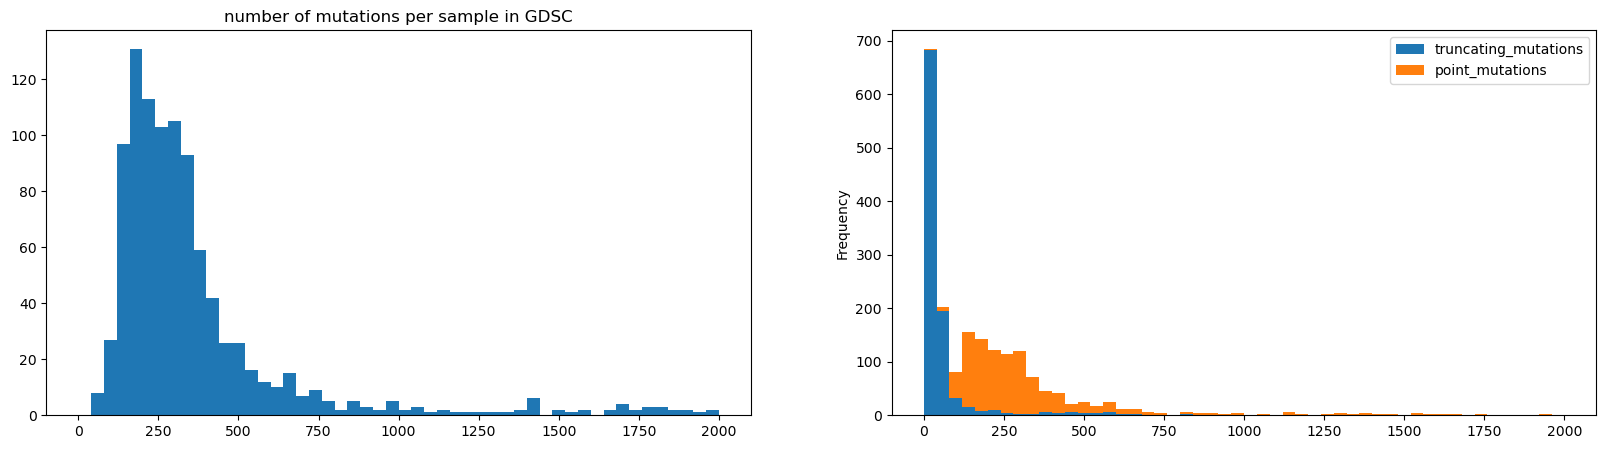

mean 485.7 median 288.0


In [56]:
# mutation plots

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
n_mutations_gdsc = gdsc.groupby("COSMIC_ID").size().sort_values(ascending = False)
tmp = plt.hist(n_mutations_gdsc, bins=50,range = (0,2000))
tmp = plt.title("number of mutations per sample in GDSC")
ax = plt.subplot(1,2,2)
n_LoF = gdsc.loc[gdsc["Classification"].isin(gdsc_truncating ),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
n_GoF = gdsc.loc[gdsc["Classification"].isin(gdsc_point),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
df = pd.DataFrame.from_dict({"truncating_mutations":n_LoF,"point_mutations":n_GoF})
#tmp = plt.hist(n_LoF, bins=50)
#tmp = plt.title("LoF mutations per sample in GDSC")
df.plot.hist(stacked = True, bins = 50,ax =ax,range = (0,2000))
plt.show()

print("mean",round(np.mean(n_mutations_gdsc),1), "median",np.median(n_mutations_gdsc))

In [57]:
# define functions for binarizing mutations and getting amino acid positions

def binarize(x):
    if x==0:
        return x
    else:
        return 1

def get_aa_pos_GDSC(x):
    l = re.findall(r'\d+', x)
    if len(l) == 0:
        #print(x, "positions not found.",file = sys.stderr)
        return ("NA","NA")
    elif len(l) == 1:
        return (int(l[0]), int(l[0]))
    else:
        return (int(l[0]), int(l[1]))

In [58]:
# get amino acid positions

gdsc["aa_pos"] = gdsc["AA"].apply(lambda x : get_aa_pos_GDSC(x))
gdsc["start"] = gdsc["aa_pos"].apply(lambda x : str(x).split(",")[0])
gdsc["end"] = gdsc["aa_pos"].apply(lambda x : str(x).split(",")[1])
gdsc.head(5)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos,start,end
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)",(281,281)
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)",(197,197)
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)",(191,191)
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)",(486,486)
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)",(257,257)


In [59]:
# count of found gene ids

ensg_genes = []
symbols = []
for gene in set(gdsc["Gene"].values):
    if gene.startswith("ENSG"):
        ensg_genes.append(gene)
        
    else:
        symbols.append(gene)
        
print("ENSEMBL gene IDs found:",len(ensg_genes))

ensg_genes = gdsc.loc[gdsc["Gene"].isin(ensg_genes), :]
gdsc_hugo =  gdsc.loc[gdsc["Gene"].isin(symbols), :]

print("Gene symbols:",len(set(gdsc_hugo["Gene"].values)))

ENSEMBL gene IDs found: 101
Gene symbols: 18989


In [60]:
# drop duplicated gene symbols

df = gdsc_hugo[["Gene"]].copy()
df.set_index("Gene",drop= False ,inplace=True)
df.drop_duplicates(inplace = True)
df.head()

,Gene
Gene,
A1BG,A1BG
A1CF,A1CF
A2M,A2M
A2ML1,A2ML1
A4D226,A4D226


In [61]:
# find mapped and unmapped gene ids

df, query2target,not_mapped  = apply_mappers(df, 
                                             ncbi_symbols, 
                                             ncbi_synonyms, 
                                             verbose = True,
                                             handle_duplicates = "keep")

Mapped: 18476 
	directly via main_mapper 16539 
	via alternative mapper 518 
	via one of multiple synonyms in alternative mapper 1394 
	LOC 25 
Unmapped: 513 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 76 
	LOC not found in Entrez 11 
	Not found at all: 426


IDs mapped to multiple target IDs are kept:
 [143872, 284697, 341019, 27177, 387119, 84530, 26165, 11321, 122945, 150082, 728642, 2122, 442444, 79949, 157777, 6241, 340578, 100289124, 8805, 127602, 387707, 728194, 345222, 84108, 91283, 84631, 144535, 245913, 388761, 4253, 163486, 54438, 283310, 84148, 57018, 284352, 5315, 283849, 339669, 23254, 23272, 119016, 340204, 64753, 64760, 25849, 286464, 129285, 4360, 10507, 4883, 10529, 5414, 23334, 114984, 440107, 256815, 23345, 57662, 165186, 399687, 54617, 84316, 200030, 10592, 57705, 246126, 1903, 92017, 126321, 10613, 374, 445815, 79741, 51586, 168850, 647060, 284565, 63895, 93081, 201625, 29086, 1954, 9127, 55719, 29099, 941, 9645, 155066, 140733, 114112, 85452, 139728, 84458, 23028, 54777, 79868]


In [62]:
# create a dataframe with all results

gdsc_hugo = gdsc_hugo.loc[~gdsc_hugo["Gene"].isin(not_mapped),:].copy()
gdsc_hugo["Entrez_gene_ID"] = gdsc_hugo["Gene"].apply(lambda x : query2target[x])
gdsc_hugo.head(10)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos,start,end,Entrez_gene_ID
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)",(281,281),1
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)",(197,197),1
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)",(191,191),1
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)",(486,486),1
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)",(257,257),1
5,909698,A1BG,p.R90H,missense,point_mutation,"(90, 90)",(90,90),1
6,905971,A1BG,p.T46M,missense,point_mutation,"(46, 46)",(46,46),1
7,909761,A1BG,p.P41fs*33,frameshift,truncating_mutation,"(41, 33)",(41,33),1
8,1327769,A1BG,p.E249D,missense,point_mutation,"(249, 249)",(249,249),1
9,1330931,A1BG,p.Y184*,nonsense,truncating_mutation,"(184, 184)",(184,184),1


In [63]:
# show hotspots

hotspots.head()

,Hugo_Symbol,aa_pos,Entrez_gene_ID
1456,ACVR1,"(206, 206)",90
1307,ACVR1,"(258, 258)",90
1128,ACVR1,"(328, 328)",90
2542,ACVR1B,"(398, 398)",91
2056,ACVR1B,"(401, 401)",91


In [64]:
# gene_id - Entrez Gene ID 
# df - all mutations in sample
#    columns: "aa_pos","function", "Entrez_gene_ID"
# hotspots - table of known hotsport  "Entrez_gene_ID" and "aa_pos"

def distance_to_hotspot(gene_id, df_gene, hotspots):
    '''Returns minimal distance between point mutation in gene and known hotspot'''
    # consider only GoF because LoF affect the whole protein and not a certian point
    df_gene = df_gene.loc[df_gene["function"] == "point_mutation"]
    df_hotspots = hotspots.loc[hotspots["Entrez_gene_ID"] == gene_id, :]
    dist = 100000
    #a = set(hotspots.loc[hotspots["Entrez_gene_ID"] == gene_id, "Entrez_gene_ID"]) & set(df["Entrez_gene_ID"].values) & set(hotspots["Entrez_gene_ID"])
    #if a:
    try:
        for s,e in set(df_gene["aa_pos"].values):
            for hs, he in set(df_hotspots["aa_pos"].values):
                dist = min(dist, abs(s-hs),abs(s-he), abs(e-hs), abs(e-he))
    except:
        dist = 100000
    return dist

In [65]:
# define a function for mutation score

def mutations2score(df, TSG, OG, hotspots, w=0.05, verbose = False):
    # define gene type
    gene_scores = {}
    for gene_id in list(set(df["Entrez_gene_ID"].values)):
        df_gene = df.loc[df["Entrez_gene_ID"] == gene_id, :]
        # functions of mutations
        mut_functions = set(df_gene["function"].values)
        if gene_id in TSG:
            # check for truncating mutations:
            # score is -1 if any
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] =-1
            else:
                # in mutation is not truncating, 
                # get the distance to closets hotspot if any 
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                # set abs. maximal of 1/(dist+1) and 2w which corresponds LoF in unannotatedd gene
                gene_scores[gene_id] = -max(1.0/(dist+1),2*w)
        elif gene_id in OG:
            if "point_mutation" in mut_functions:
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                if "truncating_mutation" in mut_functions:
                    if verbose:
                        print("GoF at dist",dist,"from hotspot in Oncogene with GoF",file = sys.stderr)
                        print(df_gene,file = sys.stderr)
                    if 1.0/(dist+1) > 2*w:
                        # if there is a mutation close to hotspot
                        # despite LoF it is likely a driver and the second copy of this gene is broken
                        # this happens in sampl 905968  in PIK3CA gene (5290)
                        gene_scores[gene_id] = 1.0/(dist+1)
                    else:
                        # otherwise we set -1 to differentiate it from neutral mutations
                        # because oncogene might turn on after domain truncation
                        gene_scores[gene_id] = -1
                else:
                    # non-hotspot mutation in non-LoF oncogene - small positive value
                    gene_scores[gene_id] = max(1.0/(dist+1),w)
            else:
                # only LoF mutations, oncogene is likely not functional or
                # it is turned-on after truncting mutations
                # therefore we set -1 to differentiate it from neutral mutations
                gene_scores[gene_id] = -1
            
            
        else: # if unknown_significance
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] = -2.0*w
            else:
                gene_scores[gene_id] = -w
    
    return gene_scores

In [66]:
# calculate mutation scores

gdsc_scores = {}
for sample in list(set(gdsc_hugo["COSMIC_ID"].values)):
    df = gdsc_hugo.loc[gdsc_hugo["COSMIC_ID"] == sample,:]
    gdsc_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
gdsc_scores = pd.DataFrame.from_dict(gdsc_scores)
gdsc_scores.fillna(0,inplace=True)

gdsc_scores.head()

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
143872,-0.05,0.0,-0.05,0.0,-0.05,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728577,-0.05,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.05,0.0,0.00,0.0,-0.05,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2050,-0.05,0.0,0.00,0.0,0.00,-0.05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10243,-0.05,0.0,0.00,0.0,-0.05,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


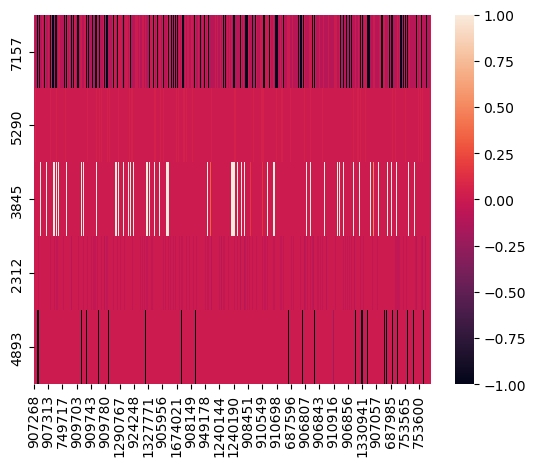

In [67]:
# example heatmap with some entrez gene ids

sns.heatmap(gdsc_scores.loc[[7157,5290,3845,2312,4893],:])
plt.show() 

In [68]:
# save results

gdsc_scores.to_csv("/Volumes/Expansion/Thesis Work/Results/preprocessed_results/mutations/GDSC.non_bin_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,4893],:]

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,-0.1,0.0,0.0,-0.1,-0.10,-0.1,-1.0,-0.1,0.0,-1.0,...,0.0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,0.0
5290,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4893,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# binarize mutation scores

gdsc_scores = gdsc_scores.applymap(lambda x: binarize(x))
gdsc_scores.to_csv("/Volumes/Expansion/Thesis Work/Results/preprocessed_results/mutations/GDSC.binary_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,2312,4893],:]

/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/106145472.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gdsc_scores = gdsc_scores.applymap(lambda x: binarize(x))


,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5290,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2312,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PDX

     * gene amplifications,deletions and mutations are mixed in one file
    * gene ID - Symobols
    * some gene IDs converted to datetime format
    * mutation types: MutKnownFunctional, MutLikelyFunctional, MutNovel. Although we failed to find an explanation of the categories. 
    * 146 duplicated muataion records found (removed)


In [70]:
# read PDX mutation dataset

pdx = pd.read_excel(pdx_dir + "nm.3954-S2.xlsx","pdxe_mut_and_cn2")
print(pdx.shape)
pdx.head(5)

(262091, 5)


,Sample,Gene,Entrez,Category,Details
0,X-1004,A2LD1,87769.0,Amp5,5.74
1,X-1004,ABCA4,24.0,MutNovel,"K1831N,0.550"
2,X-1004,ABCC13,150000.0,Amp8,8
3,X-1004,ABHD13,84945.0,Amp5,6.06
4,X-1004,ABTB1,80325.0,Amp5,6.82


In [71]:
# show mutation categories

pdx.groupby("Category").size()

Category
Amp5                    51450
Amp8                     9629
Del0.8                  77022
MutKnownFunctional      11002
MutLikelyFunctional       172
MutNovel               112816
dtype: int64

In [72]:
# remove CNA, drop duplicated records

pdx = pdx.loc[~pdx["Category"].isin(["Amp5","Amp8","Del0.8"]),:]
pdx = pdx.drop_duplicates()
print(pdx.shape)
df_size = pdx.shape[0]

(123844, 5)


In [73]:
# datetime genes

datetimes = pdx["Gene"].apply(lambda x: not isinstance(x, (str, bytes)))
datetimes = datetimes[datetimes].index

pdx_ = pdx.loc[datetimes, :]
pdx_ = pdx_.loc[(pdx_["Entrez"].notna()) & (pdx_["Entrez"] != "None"), :]

pdx_["Entrez_gene_ID"] = pd.to_numeric(pdx_["Entrez"], errors="coerce")
pdx_ = pdx_.dropna(subset=["Entrez_gene_ID"])
pdx_["Entrez_gene_ID"] = pdx_["Entrez_gene_ID"].astype(int)
pdx_["Gene"] = pdx_["Gene"].astype(str)
pdx = pdx.loc[~pdx.index.isin(datetimes), :]
pdx["Entrez"] = pdx["Entrez"].astype("Int64")

print(df_size - pdx.shape[0], "gene IDs were converted to datetimes by Excel.")
pdx.head(5)

67 gene IDs were converted to datetimes by Excel.


,Sample,Gene,Entrez,Category,Details
1,X-1004,ABCA4,24,MutNovel,"K1831N,0.550"
8,X-1004,ADAM17,6868,MutNovel,"P799T,1.000"
16,X-1004,ADCK1,57143,MutNovel,"D52G,1.000"
17,X-1004,ADNP,23394,MutNovel,"R784T,0.223"
21,X-1004,AK1,203,MutNovel,"K27N,0.430"


In [74]:
# annotate genes 

PDX_genes = pdx[["Gene"]].copy()
PDX_genes.drop_duplicates(inplace = True)
print("mutated genes in PDX cohort",PDX_genes.shape[0])
PDX_genes.set_index("Gene",drop=False,inplace=True)

mutated genes in PDX cohort 15214


In [75]:
# rename with mapper 

PDX_genes, query2target, not_mapped = apply_mappers(PDX_genes, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
pdx = pdx.loc[~pdx["Gene"].isin(not_mapped),:]
pdx["Entrez_gene_ID"] = pdx["Gene"].apply(lambda x : query2target[x])

Mapped: 15035 
	directly via main_mapper 13758 
	via alternative mapper 294 
	via one of multiple synonyms in alternative mapper 882 
	LOC 101 
Unmapped: 179 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 48 
	LOC not found in Entrez 118 
	Not found at all: 13


IDs mapped to multiple target IDs are kept:
 [143872, 286464, 653067, 284565, 144535, 284697, 341019, 4253, 51236, 440107, 9645, 644019, 399687, 6218, 23499, 84316, 200030, 6241, 119016, 84458, 374, 445815, 79741]


In [76]:
# keep not mapped genes with Entrez IDs provided

pdx_not_mapped = pdx.loc[pdx["Gene"].isin(not_mapped),:]
pdx_not_mapped = pdx_not_mapped.loc[pdx_not_mapped["Entrez"]!="None",:]
pdx_not_mapped["Entrez_gene_ID"] = pdx_not_mapped["Entrez"].apply(int)

In [77]:
# concatenate 

pdx = pd.concat([pdx,pdx_,pdx_not_mapped],axis=0)
pdx 

,Sample,Gene,Entrez,Category,Details,Entrez_gene_ID
1,X-1004,ABCA4,24.0,MutNovel,"K1831N,0.550",24
8,X-1004,ADAM17,6868.0,MutNovel,"P799T,1.000",6868
16,X-1004,ADCK1,57143.0,MutNovel,"D52G,1.000",57143
17,X-1004,ADNP,23394.0,MutNovel,"R784T,0.223",23394
21,X-1004,AK1,203.0,MutNovel,"K27N,0.430",203
...,...,...,...,...,...,...
227316,X-4378,2014-03-09 00:00:00,92979.0,MutNovel,"T107I,0.400",92979
253499,X-4597,2014-09-07 00:00:00,989.0,MutNovel,"L199F,0.484",989
257519,X-4979,2014-09-10 00:00:00,151011.0,MutNovel,"R278C,0.524",151011
259068,X-5273,2014-09-08 00:00:00,23176.0,MutNovel,"V384M,0.488",23176


In [78]:
# define positions and mutation types

pdx = pdx.sort_values(["Sample","Entrez_gene_ID"])
pdx = pdx.loc[:,["Sample","Entrez_gene_ID","Details","Gene","Category"]]
pdx.head(5)

,Sample,Entrez_gene_ID,Details,Gene,Category
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel
21,X-1004,203,"K27N,0.430",AK1,MutNovel
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel
57,X-1004,546,"P711A,1.000",ATRX,MutNovel


In [79]:
pdx.loc[pdx["Details"].str.contains("\-"),:].sort_values("Sample").shape

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/2965995742.py:1: SyntaxWarning: invalid escape sequence '\-'
  pdx.loc[pdx["Details"].str.contains("\-"),:].sort_values("Sample").shape


(10703, 5)

In [80]:
pdx.loc[pdx["Details"].str.contains("\-"),:]

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/697970222.py:1: SyntaxWarning: invalid escape sequence '\-'
  pdx.loc[pdx["Details"].str.contains("\-"),:]


,Sample,Entrez_gene_ID,Details,Gene,Category
165,X-1004,5476,"L29-,0.343",CTSA,MutNovel
702,X-1004,7157,"-342,0.972",TP53,MutKnownFunctional
547,X-1004,84876,"PP43-,1.000",ORAI1,MutNovel
652,X-1004,85414,"-549,0.414",SLC45A3,MutKnownFunctional
822,X-1004,388559,"-509,0.562",ZNF888,MutKnownFunctional
...,...,...,...,...,...
47726,X-6047,219285,"-1318,0.667",SAMD9L,MutKnownFunctional
46852,X-6047,339263,"-34?,1.000",C17orf51,MutKnownFunctional
47530,X-6047,343171,"-298?,0.500",OR2W3,MutKnownFunctional
47277,X-6047,346689,"-295?,0.643",KLRG2,MutKnownFunctional


In [81]:
pdx.loc[pdx["Gene"] == "TTN",:].sort_values("Sample")

,Sample,Entrez_gene_ID,Details,Gene,Category
49153,X-1027,7273,"G32742C,0.615",TTN,MutNovel
119703,X-1172,7273,"Y31686*,0.643",TTN,MutKnownFunctional
119704,X-1172,7273,"V24259G,1.000",TTN,MutNovel
119705,X-1172,7273,"S18836Y,1.000",TTN,MutNovel
53549,X-1210,7273,"T25276A,1.000",TTN,MutNovel
...,...,...,...,...,...
230177,X-5077,7273,"Y23861H,0.800",TTN,MutNovel
93494,X-5421,7273,"-23859,0.500",TTN,MutKnownFunctional
96493,X-5441,7273,"R22274C,1.000",TTN,MutNovel
96494,X-5441,7273,"P16086L,0.667",TTN,MutNovel


In [82]:
pdx.loc[pdx["Category"]=="MutLikelyFunctional",:].sort_values("Sample")

,Sample,Entrez_gene_ID,Details,Gene,Category
48856,X-1027,5728,"-321,0.491",PTEN,MutLikelyFunctional
118681,X-1156,7157,"R337C,0.996",TP53,MutLikelyFunctional
111432,X-1169,4436,"G322D,0.431",MSH2,MutLikelyFunctional
51808,X-1173,4089,"R361C,1.000",SMAD4,MutLikelyFunctional
52325,X-1210,2033,"D1399N,0.457",EP300,MutLikelyFunctional
...,...,...,...,...,...
45116,X-5593,7157,"G245C,0.995",TP53,MutLikelyFunctional
261929,X-5627,7157,"H193R,1.000",TP53,MutLikelyFunctional
176945,X-5645,5879,"P29S,0.548",RAC1,MutLikelyFunctional
180395,X-5696,2956,"T1219I,0.487",MSH6,MutLikelyFunctional


In [83]:
# guess mutation type from "Details" field

def guess_mut_type(x):
    mut = x.split(",")[0]
    missense_pattern = re.compile("^[A-Z][0-9]+[A-Z]$")
    indel_pattern = re.compile("^[A-Z]+[0-9]+[A-Z]+$")
    #stop_gain_pattern = re.compile("^[A-Z][0-9]+\*$")
    if bool(re.match(missense_pattern ,mut)): # missense
        return "missense"
    elif bool(re.match(indel_pattern ,mut)): # indel inframe
        return "inframe_indel"
    elif "*" in mut: #bool(re.match(stop_gain_pattern,mut)): 
        return "stop_gain_or_fs" #print(mut)
    elif "?" in mut: # splice_site
        return "ess_splice" #print(mut)
    elif bool(re.match(re.compile("^\-[0-9]+[A-Z]+$"),mut)): # -64Q - always MutNovel
        return "unrecognized_point"
    elif bool(re.match(re.compile("^\-[0-9]+$"),mut)): # -509 mostly MutKnownFunctional
        return "unrecognized_truncating"
    elif bool(re.match(re.compile("^[A-Z]+[0-9]+\-$"),mut)):  #Q72- mutNovel
        return "unrecognized_point2"
    else:
        return "unrecognized"
#for d in pdx["Details"].values:
    
pdx["Classification"] = pdx["Details"].apply(guess_mut_type)
#pdx.loc[pdx["Classification"].str.contains("unrecognized"),:].groupby(["Category","Classification"]).size()
pdx.groupby(["Classification"]).size().sort_values(ascending = False)
#pdx.loc[pdx["Classification"]=="unrecognized",:]

<>:16: SyntaxWarning: invalid escape sequence '\-'
<>:18: SyntaxWarning: invalid escape sequence '\-'
<>:20: SyntaxWarning: invalid escape sequence '\-'
<>:16: SyntaxWarning: invalid escape sequence '\-'
<>:18: SyntaxWarning: invalid escape sequence '\-'
<>:20: SyntaxWarning: invalid escape sequence '\-'
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/3897992430.py:16: SyntaxWarning: invalid escape sequence '\-'
  elif bool(re.match(re.compile("^\-[0-9]+[A-Z]+$"),mut)): # -64Q - always MutNovel
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/3897992430.py:18: SyntaxWarning: invalid escape sequence '\-'
  elif bool(re.match(re.compile("^\-[0-9]+$"),mut)): # -509 mostly MutKnownFunctional
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/3897992430.py:20: SyntaxWarning: invalid escape sequence '\-'
  elif bool(re.match(re.compile("^[A-Z]+[0-9]+\-$"),mut)):  #Q72- mutNovel


Classification
missense                   98992
inframe_indel               8557
unrecognized_truncating     4609
stop_gain_or_fs             3781
unrecognized_point2         2245
ess_splice                  2202
unrecognized_point          1643
dtype: int64

In [84]:
# find truncating and point mutations

pdx_truncating = ['stop_gain_or_fs','ess_splice',"unrecognized_truncating"]
pdx_point = ['missense','inframe_indel','unrecognized_point','unrecognized_point2']
pdx.loc[pdx["Classification"].isin(pdx_truncating),"function"] = "truncating_mutation"
pdx.loc[pdx["Classification"].isin(pdx_point),"function"] = "point_mutation"
pdx.groupby(["function"]).size().sort_values(ascending = False)

function
point_mutation         111437
truncating_mutation     10592
dtype: int64

In [85]:
# show amino acid table with mutations

pdx["aa_change"] = pdx["Details"].apply(lambda x: x.split(",")[0])
pdx["aa_pos"] = pdx["aa_change"].apply(lambda x : get_aa_pos_GDSC(x))
pdx.head()

,Sample,Entrez_gene_ID,Details,Gene,Category,Classification,function,aa_change,aa_pos
1,X-1004,24,"K1831N,0.550",ABCA4,MutNovel,missense,point_mutation,K1831N,"(1831, 1831)"
21,X-1004,203,"K27N,0.430",AK1,MutNovel,missense,point_mutation,K27N,"(27, 27)"
41,X-1004,310,"I283V,0.565",ANXA7,MutNovel,missense,point_mutation,I283V,"(283, 283)"
52,X-1004,460,"S1091C,0.443",ASTN1,MutNovel,missense,point_mutation,S1091C,"(1091, 1091)"
57,X-1004,546,"P711A,1.000",ATRX,MutNovel,missense,point_mutation,P711A,"(711, 711)"


In [86]:
# calculate per gene scores

pdx_scores = {}
for sample in list(set(pdx["Sample"].values)):
    df = pdx.loc[pdx["Sample"] == sample,:]
    pdx_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
pdx_scores = pd.DataFrame.from_dict(pdx_scores)
pdx_scores.fillna(0,inplace=True)

pdx_scores.to_csv("/Volumes/Expansion/Thesis Work/Results/preprocessed_results/mutations/PDX.non_bin_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

,X-3286,X-1948,X-3904,X-1725,X-3237,X-4138,X-1916,X-1303,X-1270,X-5693,...,X-3114,X-1480,X-1980,X-3558,X-4905,X-4624,X-2697,X-2081,X-5041,X-2880
7157,-0.1,-0.1,0.0,0.0,-0.10,-0.1,-1.0,0.0,-0.10,-0.10,...,0.0,0.0,0.0,0.0,0.0,-0.10,-1.00,-0.1,-0.1,0.00
5290,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.05,0.05,...,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.0,0.0,0.00
3845,0.0,1.0,0.0,0.0,0.00,0.0,0.0,1.0,1.00,0.00,...,0.0,1.0,0.0,0.0,0.0,0.00,1.00,1.0,1.0,0.00
2312,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,-0.05,...,0.0,0.0,0.0,0.0,0.0,-0.05,0.00,0.0,0.0,-0.05
4893,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00


In [87]:
# binarize mutation scores and save it

pdx_scores = pdx_scores.applymap(lambda x: binarize(x))
pdx_scores.to_csv("/Volumes/Expansion/Thesis Work/Results/preprocessed_results/mutations/PDX.binary_mutations.tsv",sep = "\t")
pdx_scores.loc[[7157,5290,3845,2312,4893],:]

/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/4274857339.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pdx_scores = pdx_scores.applymap(lambda x: binarize(x))


,X-3286,X-1948,X-3904,X-1725,X-3237,X-4138,X-1916,X-1303,X-1270,X-5693,...,X-3114,X-1480,X-1980,X-3558,X-4905,X-4624,X-2697,X-2081,X-5041,X-2880
7157,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
5290,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3845,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TCGA

### detected problems:
* no protein change field in 'KIPAN', 'OV', 'GBMLGG','COADREAD','LGG','KICH','KIRC' cohorts
* no input files for MESO
* protein change may be in fields "Protein_Change","amino_acid_change_WU","AAChange","amino_acid_change" 
* some missense mutations have no protein change.
* not clear what is 'R' protein change; these mutations excluded
* in some cohorts e.g. BRCA, Entrez_Gene_Id is 0 for all genes. We remapped HGNC symbols to Entrez Gene Id.
We skip mutations with Ensembl gene ID appeared in the column "Hugo_Symbol".

Cohorts and mutaions without protein change were excluded.

In [88]:
# remapping Hugo symbols to Entreze gene ids if necessary 

NCBI = pd.read_csv("/Volumes/Expansion/Thesis Work/Supplementary Files/Homo_sapiens.gene_info/Homo_sapiens.gene_info.txt",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
12 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
140871 Symbol can be mapped directly to GeneID
Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3376 Synonyms mapped to multiple GeneID
53208 different Synonyms mapped to the same GeneID
11014 Synonyms can be mapped directly to GeneID


In [89]:
# define a function to map hgnc symbols to entrez gene ids

def hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms):
    remapped_df = df[["Entrez_gene_ID","Hugo_Symbol"]].copy()
    remapped_df.drop_duplicates(inplace = True)
    remapped_df.set_index("Hugo_Symbol",inplace=True)
    remapped_df,query2target,not_mapped  = apply_mappers(remapped_df, ncbi_symbols, ncbi_synonyms,
                                                         verbose = False,handle_duplicates = "keep")
    if len(not_mapped) > 0 :
        print(len(not_mapped),"Hugo symbols not mapped to Entrez gene ID",not_mapped, file = sys.stderr)
        df = df.loc[~df["Hugo_Symbol"].isin(not_mapped),:].copy()
    df["Entrez_gene_ID"] = df["Hugo_Symbol"].apply(lambda x:query2target[x])
    return df

In [90]:
# list all TCGA cohorts

cohorts = []
for f in os.listdir(tcga_dir):
    if f.endswith("tar"):
        fp = f.replace(".tar","")
        cohort = fp.split(".")[2].replace("org_","")
        if not cohort in ["broadinstitute","KIPAN","OV",'GBMLGG','COADREAD','KIRC','KICH']: 
            cohorts.append(cohort)
cohorts.sort()
print(cohorts)
len(cohorts)


['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'STES', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM']


30

In [91]:
# define a function to read MAF files in TCGA

def read_broad_maf(df, point, truncating, protein_change = "Protein_Change"):
    df = df[["Hugo_Symbol","Entrez_Gene_Id","Variant_Classification",
                       protein_change,'Tumor_Sample_Barcode']].copy()
    #                    'Chromosome', u'Start_position', u'End_position']].copy()
    if "-Tumor" in df["Tumor_Sample_Barcode"].values[0]:
        df["Tumor_Sample_Barcode"] = df["Tumor_Sample_Barcode"].apply(lambda x : x.replace("-Tumor","") )
    df.sort_values(["Tumor_Sample_Barcode","Hugo_Symbol"], inplace=True)
    df = df.loc[~df["Variant_Classification"].isin(["3'UTR","5'Flank","5'UTR","Intron","Silent","RNA",
                                                    "De_novo_Start_OutOfFrame",'De_novo_Start_InFrame']),:]
    
    if df.shape[0] == 0:
        return df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns")
    df.loc[df["Variant_Classification"].isin(truncating),"function"] = "truncating_mutation"
    df.loc[df["Variant_Classification"].isin(point),"function"] = "point_mutation"
    df.loc[df["Variant_Classification"].isin(['Splice_Site_DNP','Splice_Site_Ins','Splice_Site_SNP',
                                              'Start_Codon_Del','Stop_Codon_DNP','Stop_Codon_Ins']),"Protein_Change"] = "NA"
    
    df["aa_pos"] =  df[protein_change].apply(lambda x : get_aa_pos_GDSC(str(x)))
    df.rename({"Entrez_Gene_Id":"Entrez_gene_ID","Tumor_Sample_Barcode":"Sample"},axis ="columns",inplace=True)
    return df

In [92]:
tcga_point = ['In_Frame_Del','In_Frame_Ins','Missense_Mutation']
tcga_truncating = ['Frame_Shift_Del','Frame_Shift_Ins','Nonsense_Mutation',
                   'Splice_Site','Translation_Start_Site','Nonstop_Mutation']

variant_types = set()
for cohort in cohorts: 
    print(cohort)
    tcga = {}
    
    # decide which mutation file to use
    proc_maf_path = "/Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Calls.Level_3.2016012800.0.0/"
    raw_maf_path = "/Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_"+cohort+".Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/"
    proc_maf_files, raw_maf_files = 0, 0 
    if os.path.exists(proc_maf_path):
        proc_maf_files = len(os.listdir(proc_maf_path))
    if os.path.exists(raw_maf_path):
        raw_maf_files =  len(os.listdir(raw_maf_path))
    # select the one with maximal number of mutations
    print("preprocessed maf",proc_maf_files,"fies;\t\traw maf:",raw_maf_files,"files",file = sys.stderr)
    if raw_maf_files > proc_maf_files:
        path = raw_maf_path
        print("select raw maf file for cohort", cohort, file =sys.stderr )
    else:
        path = proc_maf_path
        print("select processed maf file for cohort", cohort, file =sys.stderr )
    print("use path",path, file = sys.stderr)
    for fname in os.listdir(path):
        if fname.endswith(".maf.txt"):
            fname = fname.replace("._","")
            #print(fname)
            
            df = pd.read_csv(path+fname, sep = "\t", low_memory=False)
            sname = df["Tumor_Sample_Barcode"].values[0]
            variant_types = variant_types | set(df["Variant_Classification"].values)
            
            if "Protein_Change" in df.columns:
                protein_change = "Protein_Change"
            elif "amino_acid_change_WU" in df.columns:
                protein_change = "amino_acid_change_WU"
            elif "AAChange" in df.columns:
                protein_change = "AAChange"
            elif "amino_acid_change" in df.columns:
                protein_change = "amino_acid_change"
            else:
                print("Protein change columns not found in", fname, cohort,file=sys.stderr)
            df.fillna(value={protein_change:"NA"}, inplace=True)
            df = read_broad_maf(df, tcga_point, tcga_truncating, protein_change =  protein_change)
            # if all Entrez gene IDs are zeroes
            if set(df["Entrez_gene_ID"].values) == set([0]):
                # remap Hugo symbols 
                df = hgnc2entrez_mapper(df,ncbi_symbols,ncbi_synonyms)
            elif 0 in set(df["Entrez_gene_ID"].values) :
                # if zero in Entrez gene IDs, remove 
                df = df.loc[df["Entrez_gene_ID"]!=0,:]
            if df.shape[0] == 0:
                tcga[sname] = {}
            else:
                # exlued point mutations with undefined postions 
                s = df.loc[df["aa_pos"]== ("NA","NA"),:].loc[df["function"]== "point_mutation",:]
                if s.shape[0] > 0:
                    print(s[["Hugo_Symbol","Entrez_gene_ID","Variant_Classification",
                             "function",protein_change,"aa_pos"]],file = sys.stderr)
                    df = df.loc[~df.index.isin(s.index.values),:]
                    if s.shape[0] > 5:
                        print(sname, cohort,s.shape[0],"point mutations without a position",df.shape[0],"remain",file = sys.stderr)
                if df.shape[0] == 0:
                    tcga[sname] = {}
                else:
                    tcga[sname] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
                    
    # write table
    tcga = pd.DataFrame.from_dict(tcga)
    tcga.fillna(0,inplace = True)
    tcga.to_csv(preprocessed_dir+"/TCGA-"+cohort+".non_bin_mutations.tsv",sep = "\t")
    # binarize and write
    tcga= tcga.applymap(lambda x: binarize(x))
    tcga.to_csv(preprocessed_dir+"/TCGA-"+cohort+".binary_mutations.tsv",sep = "\t")

preprocessed maf 182 fies;		raw maf: 0 files
select processed maf file for cohort ACC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_ACC.Mutation_Packager_Calls.Level_3.2016012800.0.0/


ACC


   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
52        DIO3            1735      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
52        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
93        GPX1            2876      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
93        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
20      MIR662          724032      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
20        .  (NA, NA)  
     Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
2001      DNAH11            8701      Missense_Mutation  point_mutation   
1058        OAZ1            4946      Missense_Mutation  point_mutation   
1472       RIBC2           26150      Missense_Mutation  point_mutation   
1228      THSD7B           80731      Missense_Mutation  point_mutation   
2160      YTHDF3          253943      Mi

BLCA


preprocessed maf 262 fies;		raw maf: 792 files
select raw maf file for cohort BLCA
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_BLCA.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


BRCA


preprocessed maf 1966 fies;		raw maf: 0 files
select processed maf file for cohort BRCA
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_BRCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C11orf48', 'HIST1H2BG', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'MLL2', 'ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']
4 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'MARS', 'ODZ3', 'ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214970']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
2 Hugo symbols not mapped to Entrez gene ID ['GIF', 'ENSG00000261884']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']
5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DBC1', 'ODZ3', 'ENSG00000233389', 'ENSG00000237240']
9 Hugo symbols not mapped to Entrez gene ID ['ABP1', 'AIM1', 'C11orf48', 'C2orf47', 'MLL4', 'ENSG00000187461', 'ENSG00000240127', 'ENSG00000260175', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254756']
2 Hugo symbols not mapped to Entrez gene ID ['HN1', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251357']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249209']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263424']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000235041']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['CCBP2']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
1 Hugo symbols not mapped to Entrez gene ID ['DEC1']
3 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'CRIPAK', 'ENSG00000267385']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258472']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000183470']
1 Hugo symbols not mapped to Entrez gene ID ['GARS']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


7 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'FAM18B2', 'MLL2', 'MLL4', 'NOV', 'ENSG00000256349', 'FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259288']
1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']


1 Hugo symbols not mapped to Entrez gene ID ['TAZ']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MPP6']
3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'HIST1H2BC', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']
1 Hugo symbols not mapped to Entrez gene ID ['HN1']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
2 Hugo symbols not mapped to Entrez gene ID ['MARS', 'FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['TTC30B']


2 Hugo symbols not mapped to Entrez gene ID ['CCBP2', 'FLJ43860']
3 Hugo symbols not mapped to Entrez gene ID ['MLL4', 'ODZ3', 'ENSG00000257950']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260175']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'CDR1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257033']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232637']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247570']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257198']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000260861']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
4 Hugo symbols not mapped to Entrez gene ID ['CD97', 'FAM18B2', 'HIST1H2BE', 'TTC30B']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']


2 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258852']
1 Hugo symbols not mapped to Entrez gene ID ['QARS']


7 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'CSRP2BP', 'MARS', 'MLL4', 'ODZ3', 'QARS', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397']
2 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ODZ3']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256349']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'HIST1H2BC']


3 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'MLL2', 'QARS']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BF']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'AIM1', 'C15orf38', 'CCBP2', 'CD97', 'EFTUD1', 'GBA', 'MARS', 'MLL2', 'TAZ', 'TCEB3CL', 'ENSG00000235434', 'FAM86C1']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CD97']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']
4 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MLL2', 'ENSG00000251184', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BE']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000173366']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


1 Hugo symbols not mapped to Entrez gene ID ['NOV']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']
2 Hugo symbols not mapped to Entrez gene ID ['CBWD3', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['CCRL1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['QARS']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'ENSG00000248710']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


14 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CSRP2BP', 'DBC1', 'DUSP27', 'GGT2', 'MARS', 'QARS', 'TCEB3C', 'ENSG00000249624', 'MT-ATP6', 'MT-CO3', 'MT-CYB', 'MT-ND3', 'MT-ND4']
2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MLL4']
2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'FLJ43860']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MLL2', 'MLL4', 'ENSG00000258466', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['CDR1']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['TAZ']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'FLJ22184']


13 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'C2orf47', 'CSRP2BP', 'GARS', 'GIF', 'HIST1H2BG', 'MLL2', 'MUM1', 'ODZ3', 'PPYR1', 'ENSG00000184909', 'ENSG00000187461', 'ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'RPL17-C18ORF32']
2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'TRAPPC2P1']


3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'DUSP27', 'FLJ27352']
1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']
1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267261']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']
1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


4 Hugo symbols not mapped to Entrez gene ID ['PPYR1', 'TRAPPC2P1', 'CRIPAK', 'FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173366']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'SARS', 'SLC35E2']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
2 Hugo symbols not mapped to Entrez gene ID ['C2orf47', 'CD97']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'ENSG00000262323']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C11orf48', 'HIST1H2BG', 'FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'MLL2', 'ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']
4 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'MARS', 'ODZ3', 'ENSG00000260175']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214970']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
2 Hugo symbols not mapped to Entrez gene ID ['GIF', 'ENSG00000261884']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257921']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']
5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DBC1', 'ODZ3', 'ENSG00000233389', 'ENSG00000237240']
9 Hugo symbols not mapped to Entrez gene ID ['ABP1', 'AIM1', 'C11orf48', 'C2orf47', 'MLL4', 'ENSG00000187461', 'ENSG00000240127', 'ENSG00000260175', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254756']
2 Hugo symbols not mapped to Entrez gene ID ['HN1', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251357']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249209']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000226232']


1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263424']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000235041']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['CCBP2']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
1 Hugo symbols not mapped to Entrez gene ID ['DEC1']
3 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'CRIPAK', 'ENSG00000267385']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258472']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000183470']
1 Hugo symbols not mapped to Entrez gene ID ['GARS']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


7 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'FAM18B2', 'MLL2', 'MLL4', 'NOV', 'ENSG00000256349', 'FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']


1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259288']
1 Hugo symbols not mapped to Entrez gene ID ['FAM18B2']
1 Hugo symbols not mapped to Entrez gene ID ['TAZ']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MPP6']


3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'HIST1H2BC', 'FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']
1 Hugo symbols not mapped to Entrez gene ID ['HN1']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
2 Hugo symbols not mapped to Entrez gene ID ['MARS', 'FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['TTC30B']


2 Hugo symbols not mapped to Entrez gene ID ['CCBP2', 'FLJ43860']
3 Hugo symbols not mapped to Entrez gene ID ['MLL4', 'ODZ3', 'ENSG00000257950']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260175']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'CDR1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257033']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232637']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247570']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257198']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ENSG00000260861']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
4 Hugo symbols not mapped to Entrez gene ID ['CD97', 'FAM18B2', 'HIST1H2BE', 'TTC30B']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
2 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258852']
1 Hugo symbols not mapped to Entrez gene ID ['QARS']
7 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'CSRP2BP', 'MARS', 'MLL4', 'ODZ3', 'QARS', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397']
2 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ODZ3']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256349']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'HIST1H2BC']


3 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'MLL2', 'QARS']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BF']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']


13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'AIM1', 'C15orf38', 'CCBP2', 'CD97', 'EFTUD1', 'GBA', 'MARS', 'MLL2', 'TAZ', 'TCEB3CL', 'ENSG00000235434', 'FAM86C1']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CD97']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']
4 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'MLL2', 'ENSG00000251184', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BE']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184909']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000173366']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['MARS']
1 Hugo symbols not mapped to Entrez gene ID ['NOV']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000254553']


1 Hugo symbols not mapped to Entrez gene ID ['MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


2 Hugo symbols not mapped to Entrez gene ID ['CBWD3', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['CCRL1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']
2 Hugo symbols not mapped to Entrez gene ID ['HEATR8', 'ENSG00000248710']
1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
14 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CSRP2BP', 'DBC1', 'DUSP27', 'GGT2', 'MARS', 'QARS', 'TCEB3C', 'ENSG00000249624', 'MT-ATP6', 'MT-CO3', 'MT-CYB', 'MT-ND3', 'MT-ND4']


2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MLL4']
2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'FLJ43860']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['HEATR8']
1 Hugo symbols not mapped to Entrez gene ID ['C2orf47']


1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MLL2', 'MLL4', 'ENSG00000258466', 'KIAA0664']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000248710']
1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['CDR1']


1 Hugo symbols not mapped to Entrez gene ID ['ODZ3']
2 Hugo symbols not mapped to Entrez gene ID ['DBC1', 'MLL4']
1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']


1 Hugo symbols not mapped to Entrez gene ID ['TAZ']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'FLJ22184']
13 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'C2orf47', 'CSRP2BP', 'GARS', 'GIF', 'HIST1H2BG', 'MLL2', 'MUM1', 'ODZ3', 'PPYR1', 'ENSG00000184909', 'ENSG00000187461', 'ENSG00000248710']


1 Hugo symbols not mapped to Entrez gene ID ['FLJ43860']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']
2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'RPL17-C18ORF32']
2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'TRAPPC2P1']
3 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'DUSP27', 'FLJ27352']


1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']
1 Hugo symbols not mapped to Entrez gene ID ['SLC35E2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267261']
1 Hugo symbols not mapped to Entrez gene ID ['DBC1']
1 Hugo symbols not mapped to Entrez gene ID ['PPYR1']


1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


4 Hugo symbols not mapped to Entrez gene ID ['PPYR1', 'TRAPPC2P1', 'CRIPAK', 'FLJ22184']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173366']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'SARS', 'SLC35E2']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226232']


2 Hugo symbols not mapped to Entrez gene ID ['C2orf47', 'CD97']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA0664']
1 Hugo symbols not mapped to Entrez gene ID ['TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
2 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'ENSG00000262323']
1 Hugo symbols not mapped to Entrez gene ID ['MLL2']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
2 Hugo symbols not mapped to Entrez gene ID ['FAM21A', 'ODZ3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


CESC


preprocessed maf 390 fies;		raw maf: 0 files
select processed maf file for cohort CESC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_CESC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


CHOL


preprocessed maf 72 fies;		raw maf: 0 files
select processed maf file for cohort CHOL
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_CHOL.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
88            .           80167      Missense_Mutation  point_mutation   
108           .          400986      Missense_Mutation  point_mutation   
98      TSPAN14           81619      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
88         .  (NA, NA)  
108        .  (NA, NA)  
98         .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
142    ANKRD13D          338692      Missense_Mutation  point_mutation   
129       ITGB3            3690      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
142        .  (NA, NA)  
129        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        

COAD


preprocessed maf 310 fies;		raw maf: 0 files
select processed maf file for cohort COAD
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_COAD.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
83        CHL1           10752      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
83        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
11    TP53AIP1           63970      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
11        .  (NA, NA)  
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
430       MEGF8            1954      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
430        .  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function AAChange  \
4      CARD18           59082      Missense_Mutation  point_mutation        .   

    

DLBC


preprocessed maf 98 fies;		raw maf: 0 files
select processed maf file for cohort DLBC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_DLBC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


ESCA


preprocessed maf 372 fies;		raw maf: 0 files
select processed maf file for cohort ESCA
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_ESCA.Mutation_Packager_Calls.Level_3.2016012800.0.0/
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']
5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CDR1', 'KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['101928757']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000240291']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']
3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


2 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']
3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'MPP6', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']
3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214305']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']
10 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'MPP6', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']
4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']
2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']
5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']
4 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000254469', 'MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214999']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']
1 Hugo symbols not mapped to Entrez gene ID ['LOC388813']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']
4 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'QARS', 'ENSG00000259357', 'ENSG00000272268']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']
5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CDR1', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000240291']


1 Hugo symbols not mapped to Entrez gene ID ['GIF']
3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']
2 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']
3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'MPP6', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']
3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']


2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']
1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214305']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']


10 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'MPP6', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']


4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']
2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']
5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']
4 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000254469', 'MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']
2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214999']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']


1 Hugo symbols not mapped to Entrez gene ID ['LOC388813']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']
4 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'QARS', 'ENSG00000259357', 'ENSG00000272268']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


GBM


preprocessed maf 582 fies;		raw maf: 582 files
select processed maf file for cohort GBM
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_GBM.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


HNSC


preprocessed maf 560 fies;		raw maf: 1022 files
select raw maf file for cohort HNSC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_HNSC.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


KIRP


preprocessed maf 324 fies;		raw maf: 566 files
select raw maf file for cohort KIRP
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_KIRP.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


LAML


preprocessed maf 396 fies;		raw maf: 0 files
select processed maf file for cohort LAML
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_LAML.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
18        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
18      in_frame_ins  (NA, NA)  
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['LOC257039']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133292']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
2        FLT3            2322           In_Frame_Ins  point_mutation   

  amino_acid_change    aa_pos  
2      in_frame_ins  (NA, NA)  


2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100131699']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100129218', 'ENSG00000103832']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128371']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128744']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000163098']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128077']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ22167']
2 Hugo symbols not mapped to Entrez gene ID ['FLJ43860', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133915']


1 Hugo symbols not mapped to Entrez gene ID ['uc002rsf.1']
2 Hugo symbols not mapped to Entrez gene ID ['LOC644504', 'ENSG00000214135']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132800']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211894']


3 Hugo symbols not mapped to Entrez gene ID ['MT-ND1', 'MT-ND4', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100132713', 'LOC100134687']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000124399']
1 Hugo symbols not mapped to Entrez gene ID ['LOC727895']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132232']
1 Hugo symbols not mapped to Entrez gene ID ['uc004amh.1']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100133718', 'LOC730167']
3 Hugo symbols not mapped to Entrez gene ID ['ODZ3', 'LOC100128989', 'LOC100129218']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000204989']
4 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'LOC100132800', 'LOC100133684', 'MT-CO3']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'LOC730032']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100129901']
1 Hugo symbols not mapped to Entrez gene ID ['LOC644992']
1 Hugo symbols not mapped to Entrez gene ID ['uc004ewl.1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132495']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO3', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND2']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  
4 Hugo symbols not mapped to Entrez gene ID ['LOC100130734', 'LOC100132903', 'LOC387761', 'LOC727878']
1 Hugo symbols not mapped to Entrez gene ID ['LOC728896']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000198229']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100131040']
2 Hugo symbols not mapped to Entrez gene ID ['NOTCH2NL', 'LOC200493']
1 Hugo symbols not mapped to Entrez gene ID ['PRAMEF16']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215720', 'ENSG00000220279']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'uc001vvs.1']
2 Hugo symbols not mapped to Entrez gene ID ['PRG-3', 'ENSG00000211619']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216522']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133655']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
18        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
18      in_frame_ins  (NA, NA)  
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['LOC257039']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133292']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
2        FLT3            2322           In_Frame_Ins  point_mutation   

  amino_acid_change    aa_pos  
2      in_frame_ins  (NA, NA)  
2 Hugo symbols not mapped to Entrez gene ID ['MT-CYB', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100131699']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100129218', 'ENSG00000103832']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128371']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100128744']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000163098']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128077']
1 Hugo symbols not mapped to Entrez gene ID ['FLJ22167']
2 Hugo symbols not mapped to Entrez gene ID ['FLJ43860', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133915']


1 Hugo symbols not mapped to Entrez gene ID ['uc002rsf.1']
2 Hugo symbols not mapped to Entrez gene ID ['LOC644504', 'ENSG00000214135']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132800']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211894']
3 Hugo symbols not mapped to Entrez gene ID ['MT-ND1', 'MT-ND4', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100132713', 'LOC100134687']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000124399']


1 Hugo symbols not mapped to Entrez gene ID ['LOC727895']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132232']
1 Hugo symbols not mapped to Entrez gene ID ['uc004amh.1']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100133718', 'LOC730167']
3 Hugo symbols not mapped to Entrez gene ID ['ODZ3', 'LOC100128989', 'LOC100129218']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000204989']
4 Hugo symbols not mapped to Entrez gene ID ['MLL2', 'LOC100132800', 'LOC100133684', 'MT-CO3']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
2 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'LOC730032']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100129901']
1 Hugo symbols not mapped to Entrez gene ID ['LOC644992']
1 Hugo symbols not mapped to Entrez gene ID ['uc004ewl.1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CYB']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100132495']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO3', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND2']
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16        FLT3            2322           In_Frame_Ins  point_mutation   

   amino_acid_change    aa_pos  
16      in_frame_ins  (NA, NA)  
4 Hugo symbols not mapped to Entrez gene ID ['LOC100130734', 'LOC100132903', 'LOC387761', 'LOC727878']
1 Hugo symbols not mapped to Entrez gene ID ['LOC728896']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000198229']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100131040']
2 Hugo symbols not mapped to Entrez gene ID ['NOTCH2NL', 'LOC200493']


1 Hugo symbols not mapped to Entrez gene ID ['PRAMEF16']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215720', 'ENSG00000220279']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'uc001vvs.1']
2 Hugo symbols not mapped to Entrez gene ID ['PRG-3', 'ENSG00000211619']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216522']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100133655']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


LGG


preprocessed maf 574 fies;		raw maf: 1062 files
select raw maf file for cohort LGG
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_LGG.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


LIHC


preprocessed maf 398 fies;		raw maf: 748 files
select raw maf file for cohort LIHC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_LIHC.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


LUAD


preprocessed maf 462 fies;		raw maf: 1086 files
select raw maf file for cohort LUAD
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_LUAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


LUSC


preprocessed maf 358 fies;		raw maf: 0 files
select processed maf file for cohort LUSC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_LUSC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


PAAD


preprocessed maf 302 fies;		raw maf: 372 files
select raw maf file for cohort PAAD
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_PAAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


PCPG


preprocessed maf 370 fies;		raw maf: 0 files
select processed maf file for cohort PCPG
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_PCPG.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


PRAD


preprocessed maf 666 fies;		raw maf: 1000 files
select raw maf file for cohort PRAD
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_PRAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


READ


preprocessed maf 140 fies;		raw maf: 0 files
select processed maf file for cohort READ
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_READ.Mutation_Packager_Calls.Level_3.2016012800.0.0/
    Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
109      GPR158           57512      Missense_Mutation  point_mutation   
117        SSX6          280657      Missense_Mutation  point_mutation   

    AAChange    aa_pos  
109        .  (NA, NA)  
117        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
5          ASL             435      Missense_Mutation  point_mutation   
47      GPR113          165082      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
5         .  (NA, NA)  
47        .  (NA, NA)  
     Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
1840     C2orf53          339779      Missense_Mutation  point_mutation   
2266       CAPS2

SARC


preprocessed maf 496 fies;		raw maf: 0 files
select processed maf file for cohort SARC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_SARC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
2 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'ENSG00000188971']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000239012', 'MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['CNTP3']
21 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'DH10', 'DH17', 'DH6', 'DH7', 'ENSG00000188477', 'ENSG00000189275', 'ENSG00000205663', 'ENSG00000215958', 'ENSG00000221137', 'ENSG00000221379', 'ENSG00000234722', 'ENSG00000235772', 'ENSG00000237265', 'ENSG00000256982', 'ENSG00000257057', 'ENSG00000257829', 'ENSG00000260628', 'ENSG00000267943', 'KP2', 'RSEL']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216194']
4 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000215958', 'ENSG00000237357', 'MT-RNR2']
4 H

4 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000226113', 'ENSG00000266060', 'MT-RNR1']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'ENSG00000215953', 'ENSG00000268032']
2 Hugo symbols not mapped to Entrez gene ID ['LINC00846', 'ENSG00000216089']
6 Hugo symbols not mapped to Entrez gene ID ['CAC1I', 'ENSG00000203849', 'ENSG00000221121', 'ENSG00000221281', 'ENSG00000232274', 'ENSG00000267943']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206567', 'ENSG00000221280', 'ENSG00000226716', 'ENSG00000265803', 'ENSG00000268823']
12 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'AHK', 'CSPG4P8', 'ENSG00000215941', 'ENSG00000221672', 'ENSG00000223200', 'ENSG00000228463', 'ENSG00000236233', 'ENSG00000261238', 'ENSG00000266535', 'ENSG00000268889', 'V3']
7 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'CHR9', 'DJC8', 'ENSG00000187695', 'ENSG00000230333', 'ENSG00000257057', 'ENSG00000272231']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG000002

3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000237281', 'ENSG00000265002']
25 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'GS', 'CAC1E', 'CNTP5', 'CTN1', 'DAF1', 'DH17', 'DJC10', 'ENSG00000187812', 'ENSG00000203496', 'ENSG00000203849', 'ENSG00000223804', 'ENSG00000233487', 'ENSG00000237265', 'ENSG00000249509', 'ENSG00000258908', 'ENSG00000261759', 'ENSG00000265002', 'ENSG00000266817', 'ENSG00000267561', 'ENSG00000269895', 'ENSG00000271959', 'FLJ46361', 'SERPI1', 'ST6GALC1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258727']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221810', 'ENSG00000259455', 'ENSG00000269890', 'ENSG00000273312', 'KIAA1045']
11 Hugo symbols not mapped to Entrez gene ID ['GL', 'DF5', 'ENSG00000184774', 'ENSG00000203849', 'ENSG00000216173', 'ENSG00000221279', 'ENSG00000221388', 'ENSG00000224516', 'ENSG00000251273', 'MT-TY', 'TSRE1']
5 Hugo symbols not mapped to Entrez gene ID ['LOC101930494', 'DH2', 'DJB3', 'K

6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000218739', 'ENSG00000221279', 'ENSG00000221280', 'ENSG00000221307', 'ENSG00000255193', 'KC1']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CAC1B', 'ENSG00000272231']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'DH10', 'ENSG00000221388']
8 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000215923', 'ENSG00000221672', 'ENSG00000222043', 'ENSG00000225946', 'ENSG00000226145', 'ENSG00000254967', 'PLX2']
7 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000197210', 'ENSG00000226145', 'ENSG00000231611', 'ENSG00000255384', 'FLJ45139', 'IF8']
35 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'LOC101929232', 'LOC101929676', 'AHK', 'CAC1C-AS1', 'CNTP4', 'DH2', 'DH3', 'DH5', 'DH7', 'DH8', 'DH9', 'DJB11', 'DJB3', 'DJC1', 'ENSG00000161103', 'ENSG00000162947', 'ENSG00000204044', 'ENSG00000204957', 'ENSG00000205830', 'ENSG00000222961', 'ENSG00000228318', 'ENSG00000228829', 'ENSG00000229481', 'ENSG00000

2 Hugo symbols not mapped to Entrez gene ID ['LOC101928787', 'MT-RNR1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216102', 'R5-8SP6']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765', 'ENSG00000231345', 'ENSG00000250910', 'ENSG00000267075']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101928780', 'DJC13', 'ENSG00000248115', 'ENSG00000268032']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196589', 'ENSG00000221235', 'ENSG00000254551', 'ENSG00000255200']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216004', 'ENSG00000233434', 'ENSG00000240253']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'DJC1', 'ENSG00000225946']
2 Hugo symbols not mapped to Entrez gene ID ['CAC1D', 'ENSG00000215958']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236233', 'ENSG00000270012']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000245482']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221415', 'ENSG00000270433']
3 Hugo symbols no

2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'A40']
2 Hugo symbols not mapped to Entrez gene ID ['DJC11', 'RSE2']
2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000272231']
11 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'DH8', 'ENSG00000180458', 'ENSG00000215933', 'ENSG00000221279', 'ENSG00000221317', 'ENSG00000221388', 'ENSG00000221664', 'ENSG00000251966', 'ENSG00000257395', 'ENSG00000259241']
5 Hugo symbols not mapped to Entrez gene ID ['DJA4', 'EM', 'ENSG00000268673', 'PSB', 'SP91']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'P1L3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
3 Hugo symbols not mapped to Entrez gene ID ['DJC13', 'ENSG00000221810', 'ENSG00000273192']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000223730', 'MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['CAC2D4', 'ENSG00000235852', 'ENSG00000236911', 'MT-RNR1']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1G', 'ENSG00000203849', 'MT-RNR2']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216166', 'ENSG00000232274', 'ENSG00000261351']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'DH7', 'ENSG00000222033', 'ENSG00000260628', 'ENSG00000272913']
3 Hugo symbols not mapped to Entrez gene ID ['CTN3', 'DH5', 'ENSG00000263120']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000262712']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212952', 'ENSG00000221591', 'FLJ40448']
8 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'DH11', 'ENSG00000224631', 'ENSG00000230615', 'ENSG00000232274', 'ENSG00000245330', 'ENSG00000268032', 'ST6GALC3']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000213132', 'ENSG00000234722']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927091', 'ENSG00000167765', 'ENSG00000253629', 'ENSG00000263120']
5 Hugo symbols not mapped to Entrez gene ID ['APC1', 'ENSG00000216191', 'ENSG00000228302', 'MT-CO1', 

3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1C', 'ENSG00000200485']
1 Hugo symbols not mapped to Entrez gene ID ['AHK2']
3 Hugo symbols not mapped to Entrez gene ID ['A60', 'CTN2', 'DH7']
1 Hugo symbols not mapped to Entrez gene ID ['IF1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237357', 'ENSG00000266156']
4 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'ENSG00000216020', 'ENSG00000226145', 'ENSG00000258364']
3 Hugo symbols not mapped to Entrez gene ID ['DH3', 'DH5', 'NMT3']
7 Hugo symbols not mapped to Entrez gene ID ['NOV', 'DH9', 'ENSG00000207207', 'ENSG00000237031', 'ENSG00000237281', 'ENSG00000263272', 'ENSG00000267462']
4 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'FAM21A', 'ENSG00000261720', 'ENSG00000267749']
9 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'CAC1A', 'ENSG00000203849', 'ENSG00000215923', 'ENSG00000215954', 'ENSG00000224643', 'ENSG00000233825', 'ENSG0

6 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000220256', 'ENSG00000229481', 'ENSG00000244227', 'ENSG00000260158', 'ENSG00000267260']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257434']
3 Hugo symbols not mapped to Entrez gene ID ['CHR7', 'ENSG00000201913', 'ENSG00000227407']
4 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'DH8', 'ENSG00000204792', 'ENSG00000226849']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232274', 'ENSG00000235999']
4 Hugo symbols not mapped to Entrez gene ID ['CGB', 'ENSG00000239179', 'MT-RNR2', 'MT-TL1']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'DJC5B', 'ENSG00000221684', 'ENSG00000254553', 'MIR3118-6', 'MT-TF']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'CAC1A']
5 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH14', 'ENSG00000185710', 'ENSG00000215941', 'RSEK']
6 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'LOC101060604', 'DJC13', 'EH', 'ENSG00000249149', 'ENSG00000264057']
2 Hugo symbol

5 Hugo symbols not mapped to Entrez gene ID ['LOC101928102', 'DH11', 'ENSG00000221011', 'ENSG00000234978', 'ENSG00000267260']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000224505', 'PLX2']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'ENSG00000230850']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'T10']
3 Hugo symbols not mapped to Entrez gene ID ['APC4', 'ENSG00000251199', 'ENSG00000265194']
3 Hugo symbols not mapped to Entrez gene ID ['CHR9', 'ENSG00000215958', 'ENSG00000237452']
2 Hugo symbols not mapped to Entrez gene ID ['AHK', 'AHK2']
9 Hugo symbols not mapped to Entrez gene ID ['ADC', 'CTN2', 'ENSG00000242474', 'ENSG00000254665', 'ENSG00000255384', 'ENSG00000260213', 'ENSG00000267387', 'FLJ22184', 'TIG']
3 Hugo symbols not mapped to Entrez gene ID ['GBA', 'CTN2', 'ENSG00000262903']
4 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000228506', 'PLX3', 'RSET2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241']
2 Hugo symbols not m

7 Hugo symbols not mapped to Entrez gene ID ['DH2', 'ENSG00000201913', 'ENSG00000214581', 'ENSG00000215022', 'ENSG00000221295', 'ENSG00000221388', 'ENSG00000272667']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205215', 'ENSG00000268081', 'ENSG00000269688', 'ENSG00000272485', 'MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927958', 'DJC8', 'ENSG00000262112', 'KIAA1804']
3 Hugo symbols not mapped to Entrez gene ID ['MARS', 'LOC101929847', 'ENSG00000221295']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216089', 'ENSG00000237452', 'ENSG00000254592', 'ENSG00000257743', 'ENSG00000267660']
5 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000221281', 'ENSG00000265002', 'ENSG00000268845', 'LCN']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257433']
8 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000205821', 'ENSG00000221136', 'ENSG00000222717', 'ENSG00000261616', 'ENSG00000

5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221319', 'ENSG00000237234', 'ENSG00000238411', 'ENSG00000268985', 'GLU']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101928703', 'ENSG00000216020', 'ENSG00000221279']
2 Hugo symbols not mapped to Entrez gene ID ['DH7', 'RSE8']
9 Hugo symbols not mapped to Entrez gene ID ['LOC101929948', 'ALAD2', 'CAC1B', 'CAC1F', 'DH11', 'DH6', 'DH9', 'ENSG00000223164', 'IF14']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000215067', 'ENSG00000215933', 'ENSG00000221096', 'ENSG00000238737', 'ENSG00000251226']
12 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'AHK', 'CHR3', 'DH17', 'ENSG00000204038', 'ENSG00000232274', 'ENSG00000233145', 'ENSG00000242539', 'ENSG00000244306', 'ENSG00000257042', 'ENSG00000273433', 'PLX1']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101928729', 'ENSG00000263120', 'ENSG00000267353']
8 Hugo symbols not mapped to Entrez gene ID ['LOC101928921', 'DAF3', 'DJA3', 'ENSG00000204398', 'E

1 Hugo symbols not mapped to Entrez gene ID ['APC1']
5 Hugo symbols not mapped to Entrez gene ID ['LOC101929232', 'CNTP2', 'DJC13', 'ENSG00000236432', 'ENSG00000264164']
8 Hugo symbols not mapped to Entrez gene ID ['LOC101927648', 'LOC101930657', 'AHK2', 'CNTP2', 'ENSG00000215933', 'ENSG00000215953', 'ENSG00000259521', 'ENSG00000267865']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978', 'ENSG00000269688', 'ENSG00000272231']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000228436', 'ENSG00000228532', 'ENSG00000229743', 'ENSG00000260628', 'ENSG00000260973']
4 Hugo symbols not mapped to Entrez gene ID ['DH3', 'ENSG00000221696', 'ENSG00000258944', 'ENSG00000268366']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221672', 'ENSG00000221704', 'R5-8SP6']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000179253', 'ENSG00000232274', 'ENSG00000257434', 'ENSG00000267601']
5 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH2', 'ENSG00000161103', 'ENSG00

1 Hugo symbols not mapped to Entrez gene ID ['FLJ20444']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000271894']
3 Hugo symbols not mapped to Entrez gene ID ['DJB8-AS1', 'ENSG00000223063', 'ENSG00000267045']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221118', 'ENSG00000226232', 'ENSG00000268301']
6 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'CNTP5', 'ENSG00000166104', 'ENSG00000177699', 'ENSG00000215346', 'ENSG00000272231']
4 Hugo symbols not mapped to Entrez gene ID ['CAC2D1', 'DH11', 'ENSG00000215398', 'ENSG00000234719']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000227175', 'R5-8SP6']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249275', 'KATL1']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101930284', 'ENSG00000203849', 'ENSG00000221156']
2 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG00000221684']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000221664', 'ENSG00000231486', 'EN

3 Hugo symbols not mapped to Entrez gene ID ['DH11', 'DH6', 'ENSG00000253381']
5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'DH6', 'ENSG00000251273', 'ENSG00000259241', 'ENSG00000267260']
6 Hugo symbols not mapped to Entrez gene ID ['CD97', 'DJB11', 'ENSG00000229852', 'ENSG00000271828', 'RSE10', 'V3']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849']
8 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'ENSG00000171658', 'ENSG00000212939', 'ENSG00000215527', 'ENSG00000249149', 'ENSG00000257769', 'ENSG00000257931', 'ENSG00000261759']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272231', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215954', 'ENSG00000230615']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221734', 'ENSG00000255622', 'ENSG00000261200']
5 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CNTP3', 'ENSG00000221395', 'ENSG00000266885', 'ENSG00000267040']
6 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG0

3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849', 'MT-ND5', 'MT-RNR2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214397', 'FLJ46361']
5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000223291', 'ENSG00000243175', 'ENSG00000261393', 'ENSG00000272885']
4 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000206195', 'ENSG00000225411', 'ENSG00000273312']
6 Hugo symbols not mapped to Entrez gene ID ['SARS', 'LOC101927533', 'CAC1B', 'DH5', 'ENSG00000255487', 'GZ']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000265865']
7 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH8', 'ENSG00000211510', 'ENSG00000215941', 'ENSG00000221388', 'IF1', 'KC3']
1 Hugo symbols not mapped to Entrez gene ID ['KC1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216127', 'ENSG00000221395', 'ENSG00000265209', 'ENSG00000267801']
2 Hugo symbols not mapped to Entrez gene ID ['EN

93 Hugo symbols not mapped to Entrez gene ID ['ADC', 'PA', 'PSA', 'QARS', 'SHFM1', 'STRA13', 'LOC100996735', 'LOC101929518', '101928757', 'AHK', 'AHK2', 'BACH1-IT1', 'CA', 'CAC1A', 'CAC1E', 'CAC1I', 'CAC1S', 'CAC2D3', 'CHR9', 'CTN3', 'DF5', 'DH10', 'DH11', 'DH17', 'DH5', 'DH8', 'DH9', 'DJB8', 'DSE1L2', 'EB1BP2', 'ENSG00000166104', 'ENSG00000173213', 'ENSG00000177553', 'ENSG00000182873', 'ENSG00000184566', 'ENSG00000187812', 'ENSG00000204038', 'ENSG00000205018', 'ENSG00000207187', 'ENSG00000215023', 'ENSG00000221335', 'ENSG00000224113', 'ENSG00000224631', 'ENSG00000225891', 'ENSG00000228998', 'ENSG00000229839', 'ENSG00000230578', 'ENSG00000230615', 'ENSG00000231437', 'ENSG00000234232', 'ENSG00000234978', 'ENSG00000235881', 'ENSG00000238129', 'ENSG00000239674', 'ENSG00000240401', 'ENSG00000247121', 'ENSG00000249502', 'ENSG00000250046', 'ENSG00000254551', 'ENSG00000254571', 'ENSG00000254815', 'ENSG00000254844', 'ENSG00000255200', 'ENSG00000256209', 'ENSG00000257494', 'ENSG00000258017', 'E

9 Hugo symbols not mapped to Entrez gene ID ['TCEB3CL', 'CAC1G', 'DH8', 'DJC22', 'ENSG00000221104', 'ENSG00000226738', 'ENSG00000242111', 'ENSG00000259037', 'KC1']
3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'DI2', 'SERPI11']
2 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'ENSG00000188971']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221664', 'ENSG00000239012', 'MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['CNTP3']
21 Hugo symbols not mapped to Entrez gene ID ['CAC1S', 'DH10', 'DH17', 'DH6', 'DH7', 'ENSG00000188477', 'ENSG00000189275', 'ENSG00000205663', 'ENSG00000215958', 'ENSG00000221137', 'ENSG00000221379', 'ENSG00000234722', 'ENSG00000235772', 'ENSG00000237265', 'ENSG00000256982', 'ENSG00000257057', 'ENSG00000257829', 'ENSG00000260628', 'ENSG00000267943', 'KP2', 'RSEL']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216194']
4 Hugo symbols not mapped to Entrez gene ID ['DH17', 'ENSG00000215958', 'ENSG00000237357', 'MT-RNR2']
4 Hugo symbo

12 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'AHK', 'CSPG4P8', 'ENSG00000215941', 'ENSG00000221672', 'ENSG00000223200', 'ENSG00000228463', 'ENSG00000236233', 'ENSG00000261238', 'ENSG00000266535', 'ENSG00000268889', 'V3']
7 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'CHR9', 'DJC8', 'ENSG00000187695', 'ENSG00000230333', 'ENSG00000257057', 'ENSG00000272231']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229047', 'ENSG00000238009', 'ENSG00000244151', 'ENSG00000255641', 'KC5']
5 Hugo symbols not mapped to Entrez gene ID ['EB1BP2', 'ENSG00000223697', 'ENSG00000256616', 'ENSG00000270726', 'PLX2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196096', 'ENSG00000244327']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221741', 'ENSG00000222586', 'T10']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221280', 'ENSG00000233002', 'ENSG00000244306', 'MT-ND6']
18 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AHK2', 'CAC1F', 'CSGALCT1', 

4 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000216113', 'ENSG00000221684', 'MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000184566', 'ENSG00000216154', 'ENSG00000230615', 'ENSG00000270726']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234978']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216191', 'ENSG00000218416', 'ENSG00000221280', 'ENSG00000233863', 'ENSG00000260411', 'PLX2']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'ENSG00000256616']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234613', 'ENSG00000237452', 'SERPI10']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000218739', 'ENSG00000221279', 'ENSG00000221280', 'ENSG00000221307', 'ENSG00000255193', 'KC1']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CAC1B', 'ENSG00000272231']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101929847', 'DH10', 'ENSG00000221388']
8 Hugo symbols not mapped to Entrez gene ID ['DH8', 'ENSG0000021

2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216102', 'R5-8SP6']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765', 'ENSG00000231345', 'ENSG00000250910', 'ENSG00000267075']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101928780', 'DJC13', 'ENSG00000248115', 'ENSG00000268032']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000196589', 'ENSG00000221235', 'ENSG00000254551', 'ENSG00000255200']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216004', 'ENSG00000233434', 'ENSG00000240253']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'DJC1', 'ENSG00000225946']
2 Hugo symbols not mapped to Entrez gene ID ['CAC1D', 'ENSG00000215958']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236233', 'ENSG00000270012']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000245482']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221415', 'ENSG00000270433']
3 Hugo symbols not mapped to Entrez gene ID ['LOC100996870', '101928757', 'DH10']
4 Hugo 

2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000272231']
11 Hugo symbols not mapped to Entrez gene ID ['CTN2', 'DH8', 'ENSG00000180458', 'ENSG00000215933', 'ENSG00000221279', 'ENSG00000221317', 'ENSG00000221388', 'ENSG00000221664', 'ENSG00000251966', 'ENSG00000257395', 'ENSG00000259241']
5 Hugo symbols not mapped to Entrez gene ID ['DJA4', 'EM', 'ENSG00000268673', 'PSB', 'SP91']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221684', 'P1L3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
3 Hugo symbols not mapped to Entrez gene ID ['DJC13', 'ENSG00000221810', 'ENSG00000273192']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000223730', 'MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['CAC2D4', 'ENSG00000235852', 'ENSG00000236911', 'MT-RNR1']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1G', 'ENSG00000203849', 'MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['LOC440157', 'DJB2', 'ENSG00000215933', 'ENSG00000221474']
5 Hugo symbols no

2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000213132', 'ENSG00000234722']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927091', 'ENSG00000167765', 'ENSG00000253629', 'ENSG00000263120']
5 Hugo symbols not mapped to Entrez gene ID ['APC1', 'ENSG00000216191', 'ENSG00000228302', 'MT-CO1', 'MT-TS2']
6 Hugo symbols not mapped to Entrez gene ID ['LOC100507033', 'ENSG00000267219', 'ENSG00000269939', 'ENSG00000273433', 'MT-ATP8', 'PEPLD']
6 Hugo symbols not mapped to Entrez gene ID ['CAC1H', 'DH8', 'ENSG00000204398', 'ENSG00000244227', 'ENSG00000258973', 'ENSG00000266008']
9 Hugo symbols not mapped to Entrez gene ID ['DH7', 'ENSG00000224363', 'ENSG00000237452', 'ENSG00000245156', 'ENSG00000252258', 'ENSG00000257434', 'KP3', 'MT-CO1', 'MT-ND5']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'CNTP3B', 'ENSG00000204398', 'ENSG00000244306', 'ENSG00000256982', 'ENSG00000263378']
3 Hugo symbols not mapped to Entrez gene ID ['CAC1A', 'CAC1C', 'ENSG00000200485']
1 Hugo symbols not 

5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215972', 'ENSG00000227082', 'ENSG00000250186', 'ENSG00000273433', 'IF16']
6 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000220256', 'ENSG00000229481', 'ENSG00000244227', 'ENSG00000260158', 'ENSG00000267260']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257434']
3 Hugo symbols not mapped to Entrez gene ID ['CHR7', 'ENSG00000201913', 'ENSG00000227407']
4 Hugo symbols not mapped to Entrez gene ID ['AHK2', 'DH8', 'ENSG00000204792', 'ENSG00000226849']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232274', 'ENSG00000235999']
4 Hugo symbols not mapped to Entrez gene ID ['CGB', 'ENSG00000239179', 'MT-RNR2', 'MT-TL1']
6 Hugo symbols not mapped to Entrez gene ID ['AHK', 'DJC5B', 'ENSG00000221684', 'ENSG00000254553', 'MIR3118-6', 'MT-TF']
2 Hugo symbols not mapped to Entrez gene ID ['LOR', 'CAC1A']
5 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH14', 'ENSG00000185710', 'ENSG00000215941', 'RSEK']
6 Hugo

9 Hugo symbols not mapped to Entrez gene ID ['ADC', 'CTN2', 'ENSG00000242474', 'ENSG00000254665', 'ENSG00000255384', 'ENSG00000260213', 'ENSG00000267387', 'FLJ22184', 'TIG']
3 Hugo symbols not mapped to Entrez gene ID ['GBA', 'CTN2', 'ENSG00000262903']
4 Hugo symbols not mapped to Entrez gene ID ['CNTP4', 'ENSG00000228506', 'PLX3', 'RSET2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000215976']
2 Hugo symbols not mapped to Entrez gene ID ['DH9', 'FLJ41200']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253334', 'LCN']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000211996', 'ENSG00000214581', 'ENSG00000234222']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100293748', 'ENSG00000161103', 'ENSG00000227175', 'ENSG00000233207', 'IFR1']
7 Hugo symbols not mapped to Entrez gene ID ['DH2', 'ENSG00000201913', 'ENSG00000214581', 'ENSG00000215022', 'ENSG00000221295', 'ENSG00000221388', 

2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221704', 'ENSG00000258727']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221492', 'ENSG00000244227']
5 Hugo symbols not mapped to Entrez gene ID ['ENSG00000221319', 'ENSG00000237234', 'ENSG00000238411', 'ENSG00000268985', 'GLU']
3 Hugo symbols not mapped to Entrez gene ID ['LOC101928703', 'ENSG00000216020', 'ENSG00000221279']
2 Hugo symbols not mapped to Entrez gene ID ['DH7', 'RSE8']
9 Hugo symbols not mapped to Entrez gene ID ['LOC101929948', 'ALAD2', 'CAC1B', 'CAC1F', 'DH11', 'DH6', 'DH9', 'ENSG00000223164', 'IF14']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000215067', 'ENSG00000215933', 'ENSG00000221096', 'ENSG00000238737', 'ENSG00000251226']
12 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'AHK', 'CHR3', 'DH17', 'ENSG00000204038', 'ENSG00000232274', 'ENSG00000233145', 'ENSG00000242539', 'ENSG00000244306', 'ENSG00000257042', 'ENSG00000273433', 'PLX1']
3 Hugo symbols not mapped to En

4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000179253', 'ENSG00000232274', 'ENSG00000257434', 'ENSG00000267601']
5 Hugo symbols not mapped to Entrez gene ID ['CNTP5', 'DH2', 'ENSG00000161103', 'ENSG00000221544', 'ENSG00000269690']
4 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'DH2', 'FLJ46361', 'RG2']
2 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000273199']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'DH5', 'ENSG00000221244', 'ENSG00000251226']
6 Hugo symbols not mapped to Entrez gene ID ['DH12', 'ENSG00000216191', 'ENSG00000229481', 'ENSG00000259455', 'ENSG00000259966', 'I']
5 Hugo symbols not mapped to Entrez gene ID ['GIF', 'CAC1H', 'CHR5', 'DH9', 'ENSG00000207207']
3 Hugo symbols not mapped to Entrez gene ID ['DH9', 'ENSG00000226145', 'ENSG00000272231']
6 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205918', 'ENSG00000216054', 'ENSG00000226145', 'ENSG00000264576', 'GI2', 'MT-RNR1']
8 Hugo symbols not mapped to Entrez gene ID ['GS', 'E

1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000225241']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000259241', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000252677']
4 Hugo symbols not mapped to Entrez gene ID ['CAC1F', 'ENSG00000254553', 'ENSG00000257743', 'ENSG00000271959']
3 Hugo symbols not mapped to Entrez gene ID ['DH11', 'DH6', 'ENSG00000253381']
5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'DH6', 'ENSG00000251273', 'ENSG00000259241', 'ENSG00000267260']
6 Hugo symbols not mapped to Entrez gene ID ['CD97', 'DJB11', 'ENSG00000229852', 'ENSG00000271828', 'RSE10', 'V3']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000203849']
8 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'ENSG00000171658', 'ENSG00000212939', 'ENSG00000215527', 'ENSG00000249149', 'ENSG00000257769', 'ENSG00000257931', 'ENSG00000261759']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272231', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene 

5 Hugo symbols not mapped to Entrez gene ID ['DH5', 'ENSG00000223291', 'ENSG00000243175', 'ENSG00000261393', 'ENSG00000272885']
4 Hugo symbols not mapped to Entrez gene ID ['AHK', 'ENSG00000206195', 'ENSG00000225411', 'ENSG00000273312']
6 Hugo symbols not mapped to Entrez gene ID ['SARS', 'LOC101927533', 'CAC1B', 'DH5', 'ENSG00000255487', 'GZ']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215941', 'ENSG00000265865']
7 Hugo symbols not mapped to Entrez gene ID ['CAC1C', 'DH8', 'ENSG00000211510', 'ENSG00000215941', 'ENSG00000221388', 'IF1', 'KC3']
1 Hugo symbols not mapped to Entrez gene ID ['KC1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-RNR2']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216127', 'ENSG00000221395', 'ENSG00000265209', 'ENSG00000267801']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267075', 'MT-ND5']
5 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'DH14', 'ENSG00000215941', 'ENSG00000236295', 'ENSG00000272356']
6 Hugo sy

4 Hugo symbols not mapped to Entrez gene ID ['LOR', 'DH17', 'ENSG00000200294', 'ENSG00000221732']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222032', 'ENSG00000234277', 'ENSG00000251273', 'RSEL']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244227']
8 Hugo symbols not mapped to Entrez gene ID ['LOC100128374', 'AHK2', 'CAC1B', 'CAC1I', 'ENSG00000226145', 'ENSG00000242288', 'ENSG00000254967', 'FLJ44006']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000216116', 'ENSG00000254913', 'ENSG00000263606']
9 Hugo symbols not mapped to Entrez gene ID ['TCEB3CL', 'CAC1G', 'DH8', 'DJC22', 'ENSG00000221104', 'ENSG00000226738', 'ENSG00000242111', 'ENSG00000259037', 'KC1']
3 Hugo symbols not mapped to Entrez gene ID ['DH14', 'DI2', 'SERPI11']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


SKCM


preprocessed maf 692 fies;		raw maf: 736 files
select raw maf file for cohort SKCM
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_SKCM.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


STAD


preprocessed maf 580 fies;		raw maf: 792 files
select raw maf file for cohort STAD
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_STAD.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
1 Hugo symbols not mapped to Entrez gene ID ['MPP6']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['CDR1']
2 Hugo symbols not mapped to Entrez gene ID ['SLC35E2', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999', 'ENSG00000255641']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['SARS', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['LOR']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'HIST1H2BE', 'LOC101927016', '101928503']


6 Hugo symbols not mapped to Entrez gene ID ['MPP6', 'MUM1', 'QARS', 'TAZ', 'ENSG00000269808', 'SPHAR']
6 Hugo symbols not mapped to Entrez gene ID ['MARS', 'MPP6', 'QARS', 'SARS', 'ENSG00000228532', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']


5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'DUSP27', 'ENSG00000260007', 'PRAMEF16']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


13 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CSRP2BP', 'HIST1H2BF', 'MARS', 'MUM1', 'NAT6', 'NOV', 'TTC30B', '101928757', 'CRIPAK', 'ENSG00000255622', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['HN1']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
3 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000255641', 'ENSG00000259966']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'NOV']


15 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DUSP27', 'EFTUD1', 'FAM21A', 'GIF', 'MPP6', 'TTC30B', '101928757', 'CRIPAK', 'ENSG00000181495', 'ENSG00000212884', 'ENSG00000259455', 'ENSG00000263065', 'ENSG00000267561', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236432']
6 Hugo symbols not mapped to Entrez gene ID ['NAT6', 'SHFM1', 'CRIPAK', 'ENSG00000255622', 'ENSG00000273398', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['GARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000269175', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MUM1', 'CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'GBA', 'CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['LOR']
4 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000255168', 'ENSG00000268412', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000197604', 'ENSG00000232600']


9 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'EFTUD1', 'FAM21A', 'GBA', 'HIST1H2BC', 'TRAPPC2P1', 'ENSG00000228532', 'ENSG00000273398']


3 Hugo symbols not mapped to Entrez gene ID ['GGT2', 'ENSG00000234719', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'MT-ND6']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100996735', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']


3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'LOC100996735', 'ENSG00000259455']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189332']
8 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'DUSP27', 'GARS', 'GBA', 'MARS', 'SARS', 'ENSG00000180574', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251606']


13 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'GBA', 'MARS', 'MPP6', 'MUM1', 'NOV', 'CRIPAK', 'ENSG00000180574', 'ENSG00000219492', 'ENSG00000237568', 'ENSG00000269175', 'ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
5 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6', 'ENSG00000268412', 'ENSG00000269175', 'MT-ATP6']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000227091', 'ENSG00000255622', 'ENSG00000273398']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240040']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244558', 'ENSG00000255182']
2 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC', 'ENSG00000189332']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243501']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CD97', 'ENSG00000254230']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269846']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000241720']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'ENSG00000243501', 'ENSG00000255168', 'ENSG00000269175']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CSRP2BP', 'GBA', 'ENSG00000273398']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206532']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'GBA', '101928757']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250850', 'ENSG00000267976']
4 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'GBA', 'MPP6', 'MT-ND5']


7 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'DUSP27', 'EFTUD1', '101928503', 'CRIPAK', 'ENSG00000249034', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['AGPAT9']
6 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6', 'MUM1', 'SARS', 'TTC30B', 'ENSG00000272822']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'DUSP27']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574', 'ENSG00000268412', 'KIAA1804', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'GBA', 'KIAA1045']
4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'NAT6', 'CDR1', 'CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['CDR1']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197604', 'KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BF']


1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['ADC']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


6 Hugo symbols not mapped to Entrez gene ID ['C11orf48', 'GBA', 'SARS', 'ENSG00000212884', 'ENSG00000234719', 'KIAA1045']
6 Hugo symbols not mapped to Entrez gene ID ['MARS', 'MPP6', 'NAT6', 'SARS', 'ENSG00000141979', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000266956']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000267360', 'KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269175', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['CDR1']


1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND4L']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'ENSG00000267954', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['C11orf48']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']
2 Hugo symbols not mapped to Entrez gene ID ['NOV', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250692']
2 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000181495']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255641']
2 Hugo symbols not mapped to Entrez gene ID ['GIF', 'TRAPPC2P1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']
4 Hugo symbols not mapped to Entrez gene ID ['ADC', 'GARS', 'TTC30B', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['NOV']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
4 Hugo symbols not mapped to Entrez gene ID ['GARS', 'LOR', 'ENSG00000173213', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267970']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255641']
2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'QARS']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654']
3 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000205821', 'ENSG00000253917']


7 Hugo symbols not mapped to Entrez gene ID ['ADC', 'DUSP27', 'FAM21A', 'QARS', 'SLC35E2', 'ENSG00000234719', 'ENSG00000255168']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MARS', 'CRIPAK', 'ENSG00000187461']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


3 Hugo symbols not mapped to Entrez gene ID ['GBA', 'QARS', 'ENSG00000184909']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'MT-ATP6']


2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'NOTCH2NL']
4 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'FAM21A', 'HIST1H2BF', 'PRR25']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'GARS', 'ENSG00000243008']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000219492']
2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'FAM86C1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000261711']
5 Hugo symbols not mapped to Entrez gene ID ['CD97', 'CSRP2BP', 'GGT2', 'ENSG00000259966', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['101928757', 'ENSG00000180574']


1 Hugo symbols not mapped to Entrez gene ID ['PRR25']
4 Hugo symbols not mapped to Entrez gene ID ['CD97', 'EFTUD1', 'GARS', 'HIST1H2BC']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CXXC11', '101928757', 'ENSG00000269808', 'KIAA1804']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000255470']
1 Hugo symbols not mapped to Entrez gene ID ['PRR25']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MT-ND6']
9 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'SARS', 'SLC35E2', 'LOC101929271', 'ENSG00000173213', 'ENSG00000255622', 'ENSG00000268241', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['GARS', 'ENSG00000188474', 'ENSG00000255641']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000121388']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['SHFM1']


5 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'GIF', 'HIST1H2BG', 'SARS', 'CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['C11orf48', 'GBA', 'MPP6']
2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000267882']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243696', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101927016']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
2 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
1 Hugo symbols not mapped to Entrez gene ID ['MPP6']


1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['CDR1']
2 Hugo symbols not mapped to Entrez gene ID ['SLC35E2', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000214999', 'ENSG00000255641']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['SARS', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['LOR']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'HIST1H2BE', 'LOC101927016', '101928503']


6 Hugo symbols not mapped to Entrez gene ID ['MPP6', 'MUM1', 'QARS', 'TAZ', 'ENSG00000269808', 'SPHAR']
6 Hugo symbols not mapped to Entrez gene ID ['MARS', 'MPP6', 'QARS', 'SARS', 'ENSG00000228532', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']
5 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'DUSP27', 'ENSG00000260007', 'PRAMEF16']


1 Hugo symbols not mapped to Entrez gene ID ['EFTUD1']


13 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CSRP2BP', 'HIST1H2BF', 'MARS', 'MUM1', 'NAT6', 'NOV', 'TTC30B', '101928757', 'CRIPAK', 'ENSG00000255622', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['CD97']
1 Hugo symbols not mapped to Entrez gene ID ['HN1']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'HIST1H2BC']


1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
2 Hugo symbols not mapped to Entrez gene ID ['QARS', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
3 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000255641', 'ENSG00000259966']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'NOV']


15 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'DUSP27', 'EFTUD1', 'FAM21A', 'GIF', 'MPP6', 'TTC30B', '101928757', 'CRIPAK', 'ENSG00000181495', 'ENSG00000212884', 'ENSG00000259455', 'ENSG00000263065', 'ENSG00000267561', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['CXXC11']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000236432']
6 Hugo symbols not mapped to Entrez gene ID ['NAT6', 'SHFM1', 'CRIPAK', 'ENSG00000255622', 'ENSG00000273398', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['GARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000269175', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'MUM1', 'CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'GBA', 'CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['LOR']
4 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000255168', 'ENSG00000268412', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000197604', 'ENSG00000232600']


9 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'EFTUD1', 'FAM21A', 'GBA', 'HIST1H2BC', 'TRAPPC2P1', 'ENSG00000228532', 'ENSG00000273398']


3 Hugo symbols not mapped to Entrez gene ID ['GGT2', 'ENSG00000234719', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ND5', 'MT-ND6']
2 Hugo symbols not mapped to Entrez gene ID ['LOC100996735', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']


3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'LOC100996735', 'ENSG00000259455']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189332']
8 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'DUSP27', 'GARS', 'GBA', 'MARS', 'SARS', 'ENSG00000180574', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000251606']


13 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'GBA', 'MARS', 'MPP6', 'MUM1', 'NOV', 'CRIPAK', 'ENSG00000180574', 'ENSG00000219492', 'ENSG00000237568', 'ENSG00000269175', 'ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
5 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6', 'ENSG00000268412', 'ENSG00000269175', 'MT-ATP6']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000227091', 'ENSG00000255622', 'ENSG00000273398']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000240040']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000244558', 'ENSG00000255182']
2 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC', 'ENSG00000189332']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243501']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'AZI1', 'CD97', 'ENSG00000254230']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269846']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000241720']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'C10orf2', 'ENSG00000243501', 'ENSG00000255168', 'ENSG00000269175']
4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'CSRP2BP', 'GBA', 'ENSG00000273398']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000206532']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'GBA', '101928757']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250850', 'ENSG00000267976']


4 Hugo symbols not mapped to Entrez gene ID ['APITD1', 'GBA', 'MPP6', 'MT-ND5']
7 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'DUSP27', 'EFTUD1', '101928503', 'CRIPAK', 'ENSG00000249034', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'KIAA1045']
1 Hugo symbols not mapped to Entrez gene ID ['AGPAT9']


6 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'MPP6', 'MUM1', 'SARS', 'TTC30B', 'ENSG00000272822']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'DUSP27']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574', 'ENSG00000268412', 'KIAA1804', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'GBA', 'KIAA1045']
4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'NAT6', 'CDR1', 'CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['CDR1']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197604', 'KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BF']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']


1 Hugo symbols not mapped to Entrez gene ID ['ADC']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
6 Hugo symbols not mapped to Entrez gene ID ['C11orf48', 'GBA', 'SARS', 'ENSG00000212884', 'ENSG00000234719', 'KIAA1045']


6 Hugo symbols not mapped to Entrez gene ID ['MARS', 'MPP6', 'NAT6', 'SARS', 'ENSG00000141979', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['QARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000266956']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000267360', 'KIAA1045']


1 Hugo symbols not mapped to Entrez gene ID ['FAM21A']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269175', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['AIM1']
1 Hugo symbols not mapped to Entrez gene ID ['CDR1']


1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'FAM21A', 'TCEB3C']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1045']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']


4 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'ENSG00000267954', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['C11orf48']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258027']
2 Hugo symbols not mapped to Entrez gene ID ['NOV', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000250692']
2 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000181495']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255641']
2 Hugo symbols not mapped to Entrez gene ID ['GIF', 'TRAPPC2P1']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'KIAA1045']
4 Hugo symbols not mapped to Entrez gene ID ['ADC', 'GARS', 'TTC30B', '101928757']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['NOV']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
4 Hugo symbols not mapped to Entrez gene ID ['GARS', 'LOR', 'ENSG00000173213', 'ENSG00000269175']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267970']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255641']
2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'QARS']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000258654']
3 Hugo symbols not mapped to Entrez gene ID ['ADC', 'ENSG00000205821', 'ENSG00000253917']


7 Hugo symbols not mapped to Entrez gene ID ['ADC', 'DUSP27', 'FAM21A', 'QARS', 'SLC35E2', 'ENSG00000234719', 'ENSG00000255168']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000273398', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MARS', 'CRIPAK', 'ENSG00000187461']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']


3 Hugo symbols not mapped to Entrez gene ID ['GBA', 'QARS', 'ENSG00000184909']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'MT-ATP6']


2 Hugo symbols not mapped to Entrez gene ID ['CD97', 'NOTCH2NL']
4 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'FAM21A', 'HIST1H2BF', 'PRR25']
1 Hugo symbols not mapped to Entrez gene ID ['MARS']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'GARS', 'ENSG00000243008']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000219492']
2 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'FAM86C1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000261711']
5 Hugo symbols not mapped to Entrez gene ID ['CD97', 'CSRP2BP', 'GGT2', 'ENSG00000259966', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['101928757', 'ENSG00000180574']


1 Hugo symbols not mapped to Entrez gene ID ['PRR25']
4 Hugo symbols not mapped to Entrez gene ID ['CD97', 'EFTUD1', 'GARS', 'HIST1H2BC']


5 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'CXXC11', '101928757', 'ENSG00000269808', 'KIAA1804']
2 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000180574']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000255470']
1 Hugo symbols not mapped to Entrez gene ID ['PRR25']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269657']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'MT-ND6']
9 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CXXC11', 'SARS', 'SLC35E2', 'LOC101929271', 'ENSG00000173213', 'ENSG00000255622', 'ENSG00000268241', 'KIAA1804']


3 Hugo symbols not mapped to Entrez gene ID ['GARS', 'ENSG00000188474', 'ENSG00000255641']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000121388']


1 Hugo symbols not mapped to Entrez gene ID ['CRIPAK']
1 Hugo symbols not mapped to Entrez gene ID ['SHFM1']
5 Hugo symbols not mapped to Entrez gene ID ['C10orf2', 'GIF', 'HIST1H2BG', 'SARS', 'CRIPAK']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
3 Hugo symbols not mapped to Entrez gene ID ['C11orf48', 'GBA', 'MPP6']
2 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000267882']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000243696', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101927016']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG']
2 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'KIAA1804']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


STES


preprocessed maf 950 fies;		raw maf: 792 files
select processed maf file for cohort STES
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_STES.Mutation_Packager_Calls.Level_3.2016012800.0.0/
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']
5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CDR1', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000240291']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']
3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']


1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


2 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']
3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'MPP6', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']


4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']


2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214305']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']


10 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'MPP6', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']
4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']
5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']


4 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000254469', 'MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']


2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214999']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']
1 Hugo symbols not mapped to Entrez gene ID ['LOC388813']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']


4 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'QARS', 'ENSG00000259357', 'ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']
3 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'ENSG00000231171', 'ENSG00000263020']
5 Hugo symbols not mapped to Entrez gene ID ['MARS', 'NOTCH2NL', 'ENSG00000179755', 'ENSG00000267848', 'FLJ22184']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000181495', 'ENSG00000255537']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267954']
3 Hugo symbols not mapped to Entrez gene ID ['QARS', 'CDR1', 'KIAA1804']


1 Hugo symbols not mapped to Entrez gene ID ['101928757']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['CD97']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215642']
1 Hugo symbols not mapped to Entrez gene ID ['LOC100128374']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031', 'ENSG00000268864', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'ENSG00000268948']
1 Hugo symbols not mapped to Entrez gene ID ['AZI1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213', 'ENSG00000249428', 'ENSG00000255622']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'GARS']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'ENSG00000215642']
4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'ENSG00000254614', 'MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['AZI1', 'ENSG00000237452', 'ENSG00000268467']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
2 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'ENSG00000240291']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']
3 Hugo symbols not mapped to Entrez gene ID ['SARS', 'ENSG00000234719', 'ENSG00000269175']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593', 'ENSG00000225996', 'MT-CO1']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000145965', 'ENSG00000242628', 'ENSG00000257743']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000173213']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267848', 'ENSG00000269175']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234677']
1 Hugo symbols not mapped to Entrez gene ID ['C10orf2']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000228768', 'ENSG00000232748']
1 Hugo symbols not mapped to Entrez gene ID ['B3GNT1']


2 Hugo symbols not mapped to Entrez gene ID ['TTC30B', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BC']
1 Hugo symbols not mapped to Entrez gene ID ['SARS']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000189275', 'MT-ND5', 'MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MUM1']
3 Hugo symbols not mapped to Entrez gene ID ['TCEB3C', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000232866']
1 Hugo symbols not mapped to Entrez gene ID ['GIF']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217825']


3 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000212928', 'ENSG00000259966']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884', 'MT-ATP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


13 Hugo symbols not mapped to Entrez gene ID ['ADC', 'MPP6', 'ENSG00000183154', 'ENSG00000212857', 'ENSG00000215428', 'ENSG00000225996', 'ENSG00000237102', 'ENSG00000255622', 'ENSG00000257743', 'ENSG00000259455', 'ENSG00000267270', 'ENSG00000268467', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000173213', 'ENSG00000255835']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['LOC101928664']


3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'LOC100133301', 'ENSG00000205018']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000226524', 'ENSG00000259455', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['DUSP27']
4 Hugo symbols not mapped to Entrez gene ID ['LOC101927016', 'ENSG00000169203', 'ENSG00000212857', 'ENSG00000253251']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255537', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
2 Hugo symbols not mapped to Entrez gene ID ['GARS', 'FLJ46361']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101930611']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000197182', 'ENSG00000205018']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000222031']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212884']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000167765']
4 Hugo symbols not mapped to Entrez gene ID ['EFTUD1', 'ENSG00000183562', 'ENSG00000217825', 'MT-ATP6']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'MT-ND5']


4 Hugo symbols not mapped to Entrez gene ID ['DEC1', 'SEPT2', 'ENSG00000268400', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000234719', 'SPHAR']


1 Hugo symbols not mapped to Entrez gene ID ['SEPT2']
2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214305']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000215304', 'ENSG00000232274', 'MT-ATP8']
10 Hugo symbols not mapped to Entrez gene ID ['AGPAT9', 'AZI1', 'GARS', 'MARS', 'MPP6', 'ENSG00000212999', 'ENSG00000249428', 'ENSG00000260415', 'ENSG00000267848', 'ENSG00000268241']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000205018', 'MT-CO1', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['LOC101927810']
4 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BI', 'ENSG00000248801', 'ENSG00000257057', 'ENSG00000264222']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000247925']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['CD97', 'ENSG00000255641', 'ENSG00000268241']


2 Hugo symbols not mapped to Entrez gene ID ['STRA13', 'LOC101928102']
5 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'QARS', 'ENSG00000212857', 'ENSG00000268059', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['HN1L', 'MARS']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000249034']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176593']
4 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000254469', 'MT-CO1', 'MT-ND5']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000229729']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
3 Hugo symbols not mapped to Entrez gene ID ['HIST1H2BG', 'LOR', 'SEPT2']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000188474']
2 Hugo symbols not mapped to Entrez gene ID ['B3GNT1', 'ENSG00000259455']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000269490']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268412', 'ENSG00000273398']


2 Hugo symbols not mapped to Entrez gene ID ['CXXC11', 'ENSG00000183154']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
4 Hugo symbols not mapped to Entrez gene ID ['LOC100996779', 'ENSG00000217825', 'ENSG00000267848', 'ENSG00000269175']
2 Hugo symbols not mapped to Entrez gene ID ['AIM1', 'MUM1']


3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255622', 'ENSG00000257743', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000268194']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000272268']


2 Hugo symbols not mapped to Entrez gene ID ['GBA', 'ENSG00000214999']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000233539', 'ENSG00000268948']


2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000237452', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000253172', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000255154', 'ENSG00000259471']
1 Hugo symbols not mapped to Entrez gene ID ['LOC388813']


2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000267270', 'FLJ22184']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000212857', 'ENSG00000228532']
3 Hugo symbols not mapped to Entrez gene ID ['ENSG00000187811', 'ENSG00000267848', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['LOC100509091']
4 Hugo symbols not mapped to Entrez gene ID ['DUSP27', 'QARS', 'ENSG00000259357', 'ENSG00000272268']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']


4 Hugo symbols not mapped to Entrez gene ID ['ENSG00000217702', 'ENSG00000234222', 'MT-ATP6', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['ENSG00000257743', 'MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['CDR1', 'ENSG00000257743']
1 Hugo symbols not mapped to Entrez gene ID ['KIAA1804']


/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


TGCT


preprocessed maf 312 fies;		raw maf: 0 files
select processed maf file for cohort TGCT
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_TGCT.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
62      TXNRD2           10587      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
62        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
56       LTBP4            8425      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
56        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
63           .           29801      Missense_Mutation  point_mutation   
13        GRM5            2915      Missense_Mutation  point_mutation   

   AAChange    aa_pos  
63        .  (NA, NA)  
13        .  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
8

THCA


preprocessed maf 812 fies;		raw maf: 1010 files
select raw maf file for cohort THCA
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data_raw/gdac.broadinstitute.org_THCA.Mutation_Packager_Raw_Calls.Level_3.2016012800.0.0/


1 Hugo symbols not mapped to Entrez gene ID ['RP11-113D6.10']
1 Hugo symbols not mapped to Entrez gene ID ['RP11-113D6.10']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


THYM


preprocessed maf 248 fies;		raw maf: 0 files
select processed maf file for cohort THYM
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_THYM.Mutation_Packager_Calls.Level_3.2016012800.0.0/
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256530']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263264']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MPP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']


2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
4 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CDR1', 'ENSG00000243501', 'ENSG00000269089']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176984']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260415']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101930102', 'MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000256530']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000263264']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
2 Hugo symbols not mapped to Entrez gene ID ['MT-CO1', 'MT-ND5']
2 Hugo symbols not mapped to Entrez gene ID ['MPP6', 'MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['CBWD3']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
2 Hugo symbols not mapped to Entrez gene ID ['MT-ATP6', 'MT-CO1']


1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
4 Hugo symbols not mapped to Entrez gene ID ['CSRP2BP', 'CDR1', 'ENSG00000243501', 'ENSG00000269089']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']


1 Hugo symbols not mapped to Entrez gene ID ['MT-ND6']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND5']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000176984']
1 Hugo symbols not mapped to Entrez gene ID ['ENSG00000260415']
1 Hugo symbols not mapped to Entrez gene ID ['MT-CO1']
1 Hugo symbols not mapped to Entrez gene ID ['MT-ND4L']
1 Hugo symbols not mapped to Entrez gene ID ['AIM1']


2 Hugo symbols not mapped to Entrez gene ID ['LOC101930102', 'MT-ND6']
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


UCEC


preprocessed maf 498 fies;		raw maf: 0 files
select processed maf file for cohort UCEC
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_UCEC.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))


UCS


preprocessed maf 116 fies;		raw maf: 0 files
select processed maf file for cohort UCS
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_UCS.Mutation_Packager_Calls.Level_3.2016012800.0.0/
/var/folders/fg/9tfxwbns2z9bny6_29d9jxyc0000gn/T/ipykernel_72983/1507965949.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tcga= tcga.applymap(lambda x: binarize(x))
preprocessed maf 162 fies;		raw maf: 0 files
select processed maf file for cohort UVM
use path /Volumes/Expansion/Thesis Work/Datasets/TCGA/Mutation/data__2016_01_28/gdac.broadinstitute.org_UVM.Mutation_Packager_Calls.Level_3.2016012800.0.0/
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
6        MYO3B          140469      Missense_Mutation  point_mutation   
15       OBSCN           84033      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
6              NA  (NA, NA)  
15             NA  (NA, NA

UVM


  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
6        PKP3           11187      Missense_Mutation  point_mutation   

  Protein_Change    aa_pos  
6             NA  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
2        RTTN           25914      Missense_Mutation  point_mutation   

  Protein_Change    aa_pos  
2             NA  (NA, NA)  
  Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
1       ATG9A           79065      Missense_Mutation  point_mutation   

  Protein_Change    aa_pos  
1             NA  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
13        LRP1            4035      Missense_Mutation  point_mutation   
6         MDN1           23195      Missense_Mutation  point_mutation   

   Protein_Change    aa_pos  
13             NA  (NA, NA)  
6              NA  (NA, NA)  
   Hugo_Symbol  Entrez_gene_ID Variant_Classification        function  \
16      

In [93]:
#tcga.loc[[7157,5925,5290,4893],:]
tcga

,TCGA-VD-A8KH-01A-11D-A39W-08,TCGA-V4-A9F2-01A-11D-A39W-08,TCGA-VD-A8KG-01A-11D-A39W-08,TCGA-V4-A9EH-01A-11D-A39W-08,TCGA-V4-A9EL-01A-11D-A39W-08,TCGA-V4-A9EX-01A-11D-A39W-08,TCGA-V4-A9E8-01A-11D-A39W-08,TCGA-V4-A9EA-01A-11D-A39W-08,TCGA-V4-A9EU-01A-11D-A39W-08,TCGA-V4-A9EZ-01A-11D-A39W-08,...,TCGA-YZ-A985-01A-11D-A39W-08,TCGA-VD-A8K9-01A-11D-A39W-08,TCGA-WC-A87Y-01A-11D-A39W-08,TCGA-V4-A9F4-01A-11D-A39W-08,TCGA-VD-A8K7-01B-11D-A39W-08,TCGA-V3-A9ZY-01A-11D-A39W-08,TCGA-VD-AA8M-01A-11D-A39W-08,TCGA-WC-A87T-01A-11D-A39W-08,TCGA-WC-A881-01A-12D-A39W-08,TCGA-VD-AA8R-01A-11D-A39W-08
5664,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10499,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9701,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
80114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
